# Effectuez une prédiction de revenus

https://www.soladisstatistics.fr/2020/10/26/transformation-logarithmique-ancova/

https://datadesignfrench.github.io/Transformations-French.html

http://www.jybaudot.fr/Stats/indicecarts.html

https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/

http://www.jybaudot.fr/Stats/indicecarts.html

https://uohpsy2.univ-tlse2.fr/UOHPsy2/index.php?option=com_content&task=view&id=207&Itemid=30&limit=1&limitstart=1

Vous êtes employé dans une banque, présente dans de nombreux pays à travers le monde. Celle-ci souhaite cibler de nouveaux clients potentiels, plus particulièrement les jeunes en âge d'ouvrir leur tout premier compte bancaire.

Cependant, elle souhaite cibler les prospects les plus susceptibles d'avoir, plus tard dans leur vie, de hauts revenus.

L'équipe dans laquelle vous travaillez a donc reçu pour mission de créer un modèle permettant de déterminer le revenu potentiel d'une personne.

Très bien.

"Quelles informations avons-nous ?" demandez-vous à votre supérieur, qui vous répond : "À vrai dire... quasiment aucune : uniquement le revenu des parents, car nous allons cibler les enfants de nos clients actuels, ainsi que le pays où ils habitent. C'est tout ! Ah oui, une dernière chose : ce modèle doit être valable pour la plupart des pays du monde. Je vous laisse méditer là-dessus… Bon courage !"

Avec aussi peu de données disponibles, cela semble être un sacré challenge !

Ainsi, vous proposez une régression linéaire avec 3 variables :

le revenu des parents ;
le revenu moyen du pays dans lequel habite le prospect ;
l'indice de Gini calculé sur les revenus des habitants du pays en question. 

### Import des librairies et définition des fonctions utilisées plus tard.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import datetime 
from sklearn import decomposition
from sklearn import preprocessing
#from functions import *
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from scipy.stats import norm
import re
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from scipy.stats import norm
from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D


import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# fonction clé primaire
def test_primary_key(df, column):
        if len(df) == len(df[column].drop_duplicates()):
                print("la clé  est unique")
        else : print('la clé n est pas unique')
        print('___')

#obsolète. A mettre de côté puis supprimer
def test_valeurs_manquantes(df):
    print(df.isin(['NaN']).any())

#fonction is_null
def test_is_null(df):
    print('Test de chaque variable avec isnull')
    print(df.isnull().sum())
    print('___')

#fonction affichage médiane
def func_affichage_mediane(df, column, unite):
    print('la valeur mediane est de {}'.format(df[column].median()), unite)

#fonction affichage moyenne
def func_affichage_moyenne(df, column, unite):
    print('la valeur moyenne est de {}'.format(df[column].mean()), unite)

#Au préalable on crée une fonction pour connaître notre nombre de ligne supprimées
def pourcentage_supprimé(df, df_supprimé):
    print('Le pourcentage de lignes supprimées est de: {:.4f}'.format(len(df_supprimé)/len(df)*100), '%.',\
          '{}'.format(len(df_supprimé)), 'lignes ont été supprimées' ) 
    print('sur {}'.format(len(df_supprimé)+len(df)))


def short_function_analyse_univariée(df,column):
    print('la valeur mediane de {} est de {}'.format(column, df[column].median()))
    print('la valeur moyenne de {} est de {}'.format(column, df[column].mean()))
    print('___')

### Lecture et affichage des dataframes donnés.

Ici on a notre dataframe contenant 116 pays. Il regroupe notamment les revenus de chaque centile de chaque pays, le gdpppp de chaque pays.

In [3]:
df_datap7 = pd.read_csv('data-projet7.csv', decimal=',')
#df_datap7['income'] = df_datap7['income'].str.replace(',','.').astype(float)
df_datap7

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.00000
1,ALB,2008,2,100,916.66235,7297.00000
2,ALB,2008,3,100,1010.91600,7297.00000
3,ALB,2008,4,100,1086.90780,7297.00000
4,ALB,2008,5,100,1132.69970,7297.00000
...,...,...,...,...,...,...
11594,COD,2008,96,100,810.62330,303.19305
11595,COD,2008,97,100,911.78340,303.19305
11596,COD,2008,98,100,1057.80740,303.19305
11597,COD,2008,99,100,1286.60290,303.19305


Les quantiles sont les valeurs qui divisent un jeu de données en intervalles de même probabilité égale.

Un décile est chacune des 9 valeurs qui divisent un jeu de données, triées selon une relation d'ordre, en 10 parts égales, de sorte que chaque partie représente 1/10 de l'échantillon de population.

Une population est un ensemble d'éléments ou d'événements similaires présentant un intérêt pour une question ou une expérience

Un échantillon est un ensemble d'individus représentatifs d'une population

------------------------------

Ici on a les indices de Gini pour chaque pays. L'idée va être de combiner les dataframe pour n'en avoir qu'un seul.

Pour rappel, l'indice de Gini, est une mesure statistique permettant de rendre compte de la répartition d'une variable au sein d'une population. Autrement dit, il mesure le niveau d'inégalité de la répartition d'une variable dans la population.

In [4]:
df_pov_gini = pd.read_csv('POV_GINI.csv', skiprows=3)
df_pov_gini

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
0,Aruba,ABW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,26.3,27.3,26.5,26.7,29.0,NaN,NaN,NaN,NaN,NaN
262,"Yemen, Rep.",YEM,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,36.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,South Africa,ZAF,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264,Zambia,ZMB,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,57.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ici dans ce dataframe ce qui est intéressant est que l'on a la classe de revenu de chaque pays, ainsi que la region dans laquelle est le pays.

In [5]:
df_Metadata_country = pd.read_csv('donnees_entree/Metadata_Country_API_SI.POV.GINI.csv')
df_Metadata_country

,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN
...,...,...,...,...,...,...
260,XKX,Europe & Central Asia,Upper middle income,NaN,Kosovo,NaN
261,YEM,Middle East & North Africa,Low income,The World Bank systematically assesses the app...,"Yemen, Rep.",NaN
262,ZAF,Sub-Saharan Africa,Upper middle income,Fiscal year end: March 31; reporting period fo...,South Africa,NaN
263,ZMB,Sub-Saharan Africa,Low income,National accounts data were rebased to reflect...,Zambia,NaN


In [6]:
df_Metadata_Indicator = pd.read_csv('donnees_entree/Metadata_Indicator_API_SI.POV.GINI_DS2.csv')
df_Metadata_Indicator

,INDICATOR_CODE,INDICATOR_NAME,SOURCE_NOTE,SOURCE_ORGANIZATION,Unnamed: 4
0,SI.POV.GINI,Gini index,Gini index measures the extent to which the di...,"World Bank, Poverty and Inequality Platform. D...",NaN


# Mission 1

Résumez les données utilisées :
- Année(s) des données utilisées
- Nombre de pays présents
- Population couverte par l'analyse (en termes de pourcentage de la population mondiale)


In [7]:
df_Metadata_country = df_Metadata_country.rename(columns={'TableName':'Area'})
df_Metadata_country

,Country Code,Region,IncomeGroup,SpecialNotes,Area,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN
...,...,...,...,...,...,...
260,XKX,Europe & Central Asia,Upper middle income,NaN,Kosovo,NaN
261,YEM,Middle East & North Africa,Low income,The World Bank systematically assesses the app...,"Yemen, Rep.",NaN
262,ZAF,Sub-Saharan Africa,Upper middle income,Fiscal year end: March 31; reporting period fo...,South Africa,NaN
263,ZMB,Sub-Saharan Africa,Low income,National accounts data were rebased to reflect...,Zambia,NaN


In [8]:
len(df_Metadata_country)

265

### Création de la table population

In [9]:
#là on a le nom des pays, le country code. Si on merge une table de population avec, on pourra avoir une table avec tout.
#Il faudra ensuite merge cette table avec celle de notre échantillon de façon à pouvoir calculer notre population couverte par l'échabntillon

df_population = pd.read_csv('population.csv')
df_population['Value'] *= 1000
display(len(df_population))
display(df_population.head(1))

#comme dans les projets précédents, on ne garde que la Chine
df_population = df_population.loc[~df_population['Area'].isin(['China, Hong Kong SAR', 'China, Macao SAR', 'China, mainland']) ,:]


231

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,27722276.0,X,International reliable sources,NaN


In [10]:
df_population

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,27722276.0,X,International reliable sources,NaN
1,OA,Annual population,3,Albania,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,3002678.0,X,International reliable sources,NaN
2,OA,Annual population,4,Algeria,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,34730608.0,X,International reliable sources,NaN
3,OA,Annual population,5,American Samoa,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,57492.0,X,International reliable sources,NaN
4,OA,Annual population,6,Andorra,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,83862.0,X,International reliable sources,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,OA,Annual population,243,Wallis and Futuna Islands,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,13578.0,X,International reliable sources,NaN
227,OA,Annual population,205,Western Sahara,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,468633.0,X,International reliable sources,"UNDESA, Population Division – World Population..."
228,OA,Annual population,249,"Yemen, Rep.",511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,21892146.0,X,International reliable sources,NaN
229,OA,Annual population,251,Zambia,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,12848530.0,X,International reliable sources,NaN


In [11]:
#Obsolète
#on pourrait faire du scraping sur cette page https://www.iso.org/obp/ui/#search pour ensuite récupérer la liste des alpha 3,
#on merge la liste scrapée avec nos country code. Ce qui nous permettra de dégager tous ceux qui ne se trouvent pas dans la liste.

#https://www.edureka.co/blog/web-scraping-with-python/

### Maintenant l'idée est de joindre notre notre data p7 avec la table population pour mesure la population couverte par l'analyse. Pour cela on va merge ces 2 dataframe par le biais des codes pays à 3 lettres.

In [12]:
df_Metadata_country

,Country Code,Region,IncomeGroup,SpecialNotes,Area,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN
...,...,...,...,...,...,...
260,XKX,Europe & Central Asia,Upper middle income,NaN,Kosovo,NaN
261,YEM,Middle East & North Africa,Low income,The World Bank systematically assesses the app...,"Yemen, Rep.",NaN
262,ZAF,Sub-Saharan Africa,Upper middle income,Fiscal year end: March 31; reporting period fo...,South Africa,NaN
263,ZMB,Sub-Saharan Africa,Low income,National accounts data were rebased to reflect...,Zambia,NaN


In [13]:
df_pop_ISO = pd.merge(df_Metadata_country, df_population, how='outer', indicator=True)
df_pop_ISO = df_pop_ISO[['Country Code', 'Area', 'Value', '_merge']]
df_pop_ISO.rename(columns={'Country Code':'alpha-3'}, inplace=True)
df_pop_ISO

#mettre un alpha 3 code à Taiwan

,alpha-3,Area,Value,_merge
0,ABW,Aruba,101358.0,both
1,AFE,Africa Eastern and Southern,NaN,left_only
2,AFG,Afghanistan,27722276.0,both
3,AFW,Africa Western and Central,NaN,left_only
4,AGO,Angola,21695634.0,both
...,...,...,...,...
289,NaN,Sao Tome and Principe,171120.0,right_only
290,NaN,Tokelau,1126.0,right_only
291,NaN,United States Virgin Islands,106756.0,right_only
292,NaN,Wallis and Futuna Islands,13578.0,right_only


In [14]:
#du coup, merge de notre df_pop_iso avec note cc.csv. On ne gardera donc que les lignes où les 2 sont identiques.
df_CC = pd.read_csv('CC.csv')
df_CC = df_CC[['alpha-3']]
#df_CC

In [15]:
df_pop_ISO_nettoye = pd.merge(df_CC, df_pop_ISO, how='inner', indicator='merge371Y39')
df_pop_ISO_nettoye.drop(columns={'_merge', 'merge371Y39'}, inplace=True)
df_pop_ISO_nettoye.rename(columns={'alpha-3':'country'},inplace=True)
df_pop_ISO_nettoye

,country,Area,Value
0,AFG,Afghanistan,27722276.0
1,ALB,Albania,3002678.0
2,DZA,Algeria,34730608.0
3,ASM,American Samoa,57492.0
4,AND,Andorra,83862.0
...,...,...,...
210,VGB,British Virgin Islands,26097.0
211,VIR,Virgin Islands (U.S.),NaN
212,YEM,"Yemen, Rep.",21892146.0
213,ZMB,Zambia,12848530.0


In [16]:
#donc là j'ai ma liste des pays avec leur iso alpha 3 et leur population. 
#Je peux donc merge avec mon dataset de 116 pays pour avoir la population couverte

In [17]:
#df_datap7
#PSE et XKX gdpppp manquent à l'appel

In [18]:
test_primary_key(df_datap7,'country')
test_primary_key(df_pop_ISO_nettoye, 'country')

la clé n est pas unique
___
la clé  est unique
___


In [19]:
df_datap7 = pd.merge(df_datap7, df_pop_ISO_nettoye, how='left')

In [20]:
df_datap7.loc[df_datap7['Value'].isnull(),:]

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value
5800,XKX,2008,1,100,437.89370,NaN,NaN,NaN
5801,XKX,2008,2,100,508.17133,NaN,NaN,NaN
5802,XKX,2008,3,100,591.82820,NaN,NaN,NaN
5803,XKX,2008,4,100,668.00000,NaN,NaN,NaN
5804,XKX,2008,5,100,730.40220,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
11294,PSE,2009,96,100,2763.88480,NaN,West Bank and Gaza,NaN
11295,PSE,2009,97,100,3077.83330,NaN,West Bank and Gaza,NaN
11296,PSE,2009,98,100,3449.22240,NaN,West Bank and Gaza,NaN
11297,PSE,2009,99,100,4165.99700,NaN,West Bank and Gaza,NaN


In [21]:
#on va devoir rename tous les pays problématiques du fichier population

In [22]:
#Il faudra penser à retirer la population de Taiwan, du Kosovo, et de Gaza à la population totale. En effet, on a déjà la Chine dans nos données,
#et c'est un agrégat de plusieurs pays dont Taiwan. Il ne faut donc pas le compter 2 fois.

## Population couverte par l'analyse

In [23]:
print('La population couverte par l\'analyse est de {} personnes'.format(df_datap7['Value'].sum()/100))

La population couverte par l'analyse est de 6245447162.35 personnes


## Année des données utilisées

Année des données utilisées : 2004 2006 2007 2008 2009 2010 2011

In [24]:
df_datap7.head(1)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value
0,ALB,2008,1,100,728.89795,7297.0,Albania,3002678.0


In [25]:
print('Les années des données utilisées sont {}'.format(df_datap7['year_survey'].sort_values().unique()))

Les années des données utilisées sont [2004 2006 2007 2008 2009 2010 2011]


## Nombre de pays présents

In [26]:
df_datap7_nb_pays = df_datap7.groupby(['country']).agg(['nunique']).reset_index()
len(df_datap7_nb_pays)

116

116 pays présents

### Problème avec Taiwan (et problème avec LTU)

In [27]:
df_verif = df_datap7.groupby(['country']).sum()
df_verif.sort_values(by='nb_quantiles', ascending=True)

#Il manque un quantile, et donc une valeur à la Lithuanie

,year_survey,quantile,nb_quantiles,income,gdpppp,Value
country,,,,,,
LTU,198792,5009,9900,6.574835e+05,1739529.00,3.180736e+08
ALB,200800,5050,10000,2.994830e+05,729700.00,3.002678e+08
PAN,200900,5050,10000,5.135139e+05,1176700.00,3.516204e+08
PAK,200800,5050,10000,8.878393e+04,233500.00,1.716490e+10
NPL,201000,5050,10000,9.143917e+04,104818.08,2.666658e+09
...,...,...,...,...,...,...
FIN,200800,5050,10000,1.630633e+06,3362600.00,5.319449e+08
EST,200800,5050,10000,7.702063e+05,1877300.00,1.340073e+08
ESP,200800,5050,10000,1.311699e+06,2833600.00,4.606881e+09


In [28]:
df_datap7.loc[df_datap7['country'].isin(['LTU']), :]

#Il manque une valeur. En parcourant graphiquement le dataframe, on remarque qu'il s'agit de la valeur 41 de la Lithuanie.
#Ici j'avais parcouru le Dataframe avec Deepnote, puisque c'est sur ce support que j'ai réalisé mon projet.

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value
6200,LTU,2008,1,100,566.3453,17571.0,Lithuania,3212865.0
6201,LTU,2008,2,100,1147.0587,17571.0,Lithuania,3212865.0
6202,LTU,2008,3,100,1490.8408,17571.0,Lithuania,3212865.0
6203,LTU,2008,4,100,1746.5715,17571.0,Lithuania,3212865.0
6204,LTU,2008,5,100,1842.9542,17571.0,Lithuania,3212865.0
...,...,...,...,...,...,...,...,...
6294,LTU,2008,96,100,14597.0360,17571.0,Lithuania,3212865.0
6295,LTU,2008,97,100,15659.0080,17571.0,Lithuania,3212865.0
6296,LTU,2008,98,100,17883.8770,17571.0,Lithuania,3212865.0
6297,LTU,2008,99,100,22551.1700,17571.0,Lithuania,3212865.0


### Là je calcule l'income moyen des lignes 40 et 42 pour pouvoir l'ajouter à la ligne 41.

In [29]:
income_precedent = df_datap7.loc[(df_datap7['country']=='LTU') & (df_datap7['quantile']==40)]
income_precedent

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value
6239,LTU,2008,40,100,4868.4507,17571.0,Lithuania,3212865.0


In [30]:
income_suivant = df_datap7.loc[(df_datap7['country']=='LTU') & (df_datap7['quantile']==42)]
income_suivant

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value
6240,LTU,2008,42,100,4895.8306,17571.0,Lithuania,3212865.0


In [31]:
income_suivant['income']

6240    4895.8306
Name: income, dtype: float64

In [32]:
income_nouvelle_ligne = df_datap7.loc[(df_datap7['country']=='LTU') & (df_datap7['quantile']==40) | (df_datap7['country']=='LTU') & (df_datap7['quantile']==42)]['income'].mean()
income_nouvelle_ligne

4882.14065

In [33]:
df_datap7.head(1)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value
0,ALB,2008,1,100,728.89795,7297.0,Albania,3002678.0


In [34]:
df_datap7.loc[6239.5] = ['LTU', 2008, 41, 100, income_nouvelle_ligne, 17571, 'Lithuania', 3212865.0]
df_datap7 = df_datap7.sort_index().reset_index(drop=True)
df_datap7

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value
0,ALB,2008,1,100,728.89795,7297.00000,Albania,3002678.0
1,ALB,2008,2,100,916.66235,7297.00000,Albania,3002678.0
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,3002678.0
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,3002678.0
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,3002678.0
...,...,...,...,...,...,...,...,...
11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195.0
11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195.0
11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195.0
11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195.0


In [35]:
#fonctions pour enlever les "" et les espaces. Obsolète. A mettre dans ma partie cours.

#df_country_codes = df_country_codes.applymap(lambda x: x.replace('"', ''))

#j'enlève les espaces parasites
#df_country_codes['Code_Zone'] = df_country_codes['Code_Zone'].str.strip()

#df_population['Code_Zone'] = df_population['Code_Zone'].str.strip()
#str strip bien pour enlever tous les espaces invisibles d'une colonne

##################

#On crée 2 listes avec seulement les pays de nos dataframe, pour pouvoir ensuite les comparer
#et comprendre quel pays est manquant
#df_datap7_nb_pays = df_datap7_nb_pays['Code_Zone'].copy()
#df_population_echantillon_2 = df_population_echantillon['Code_Zone'].copy()
#x = [i for i, j in zip(df_datap7_nb_pays, df_population_echantillon_2) if i != j]

## De quels quartiles s'agit-il ?

Il s'agit de centiles.

## Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?

La fonction quantile est un moyen de décrire la dispersion d'une loi. Si on réalise un grand nombre de tirages indépendants de la même loi (un échantillon), on doit s'attendre à ce qu'une proportion $ u$ des valeurs soient inférieures à $ Q_X(u)$. Une valeur importante est la médiane , $ Q_X(0.5)$. Les fonctions quantiles sont souvent utilisées en statistiques. On calcule en particulier fréquemment des intervalles de dispersion, compris comme devant contenir une forte proportion des données.

Les quantiles d'un échantillon statistique de nombres sont des valeurs remarquables permettant de diviser le jeu de ces données ordonnées (i.e. triées) en intervalles consécutifs contenant le même nombre de données

Les quantiles sont des mesures utiles parce qu'elles sont moins sensibles aux distributions allongées et aux valeurs aberrantes. Par exemple, avec une valeur aléatoire qui suit une distribution exponentielle, n'importe quel échantillon particulier de cette variable aléatoire aura approximativement une chance de 63 % d'être inférieur à la moyenne. Ceci est dû à la présence d'une longue queue de la distribution exponentielle dans les valeurs positives, qui est absente dans les valeurs négatives.

Empiriquement, si les données que vous analysez ne sont pas distribuées comme la distribution que vous attendiez, ou si une autre source de valeurs aberrantes influe sur la valeur de la moyenne, alors les quantiles sont des statistiques bien plus utiles que la moyenne ou autres types de moments statistiques.

La régression robuste est fortement liée à ce sujet. Elle utilise la somme des valeurs absolues des valeurs observées, au lieu des erreurs au carré. La connexion se situe sur le fait que la moyenne est parmi les estimateurs liés à une distribution le seul qui minimise l'espérance du carré des erreurs, tandis que la médiane minimise l'espérance de l'erreur absolue. La régression robuste partage la capacité d'être relativement insensible aux larges déviations dues à certaines observations aberrantes.

Les quantiles d'une variable aléatoire sont préservés lors de transformations croissantes, ce qui signifie par exemple que si m est la médiane d'une variable aléatoire X alors 2m est la médiane de 2X, à moins qu'un choix arbitraire ait été fait à partir d'une plage de valeurs, pour spécifier un quantile particulier. Les quantiles peuvent aussi être utilisés dans les cas où seulement des données ordinales sont disponibles.

## $PPP

Parité pouvoir d'achat. 

La parité de pouvoir d'achat (PPA) est un taux de conversion monétaire qui permet d'exprimer dans une unité commune les pouvoirs d'achat des différentes monnaies. Ce taux exprime le rapport entre la quantité d'unités monétaires nécessaire dans des pays différents pour se procurer le même « panier » de biens et de services.

Ce taux de conversion peut être différent du « taux de change » ; en effet, le taux de change d'une monnaie par rapport à une autre reflète leurs valeurs réciproques sur les marchés financiers internationaux et non leurs valeurs intrinsèques pour un consommateur.

# Mission 2

In [36]:
#Pour rappel, notre dataframe de travail ressemble à ceci.

df_datap7

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value
0,ALB,2008,1,100,728.89795,7297.00000,Albania,3002678.0
1,ALB,2008,2,100,916.66235,7297.00000,Albania,3002678.0
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,3002678.0
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,3002678.0
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,3002678.0
...,...,...,...,...,...,...,...,...
11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195.0
11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195.0
11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195.0
11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195.0


## Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.

Pour rappel, l'indice de Gini est une mesure statistique permettant de rendre compte de la répartition d'une variable au sein d'une population. Iil mesure le niveau d'inégalité de la répartition d'une variable dans la population.

## Représentez la courbe de Lorenz de chacun des pays choisis.



Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.

## 
Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?

In [37]:
df_pov_gini.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
0,Aruba,ABW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df_pov_gini_melted = pd.melt(df_pov_gini, id_vars=['Country Code'],value_vars=['2004', '2006', '2007', '2008', '2009', '2010', '2011'],var_name='Annee', value_name='Gini')
#là on a donc note dataframe melted contenant uniquement les indices de Gini

#sur notre dataframe contenant uniquement les indices de Gini, on veut supprimer les row contenant des NaN
df_pov_gini_melted_sans_NaN = df_pov_gini_melted[df_pov_gini_melted['Gini'].notna()]
df_pov_gini_melted_sans_NaN.reset_index(inplace=True)
df_pov_gini_melted_sans_NaN = df_pov_gini_melted_sans_NaN.drop(columns=['index'])
df_pov_gini_melted_sans_NaN.rename(columns={'Country Code':'country', 'Annee':'year_survey'}, inplace=True)
df_pov_gini_melted_sans_NaN

,country,year_survey,Gini
0,ARG,2004,48.4
1,ARM,2004,37.5
2,AUS,2004,33.1
3,AUT,2004,29.8
4,AZE,2004,26.6
...,...,...,...
525,UKR,2011,24.6
526,URY,2011,42.2
527,USA,2011,40.9
528,XKX,2011,27.8


Au dessus on peut remarquer qu'on a un long dataframe de 530 lignes. Il n'y a bien sûr pas 530 pays, mais on a des "doublons" puisque certains pays ont plusieurs indices de Gini sur plusieurs années.

In [39]:
df_pov_gini_melted_sans_NaN.sort_values(by='country', inplace=True)
df_pov_gini_melted_sans_NaN

,country,year_survey,Gini
216,AGO,2008,42.7
217,ALB,2008,30.0
0,ARG,2004,48.4
218,ARG,2008,44.9
70,ARG,2006,46.3
...,...,...,...
289,ZAF,2008,63.0
451,ZMB,2010,55.6
145,ZMB,2006,54.6
69,ZMB,2004,54.3


In [40]:
df_datap7.head(1)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value
0,ALB,2008,1,100,728.89795,7297.0,Albania,3002678.0


In [41]:
df_pov_gini_melted_sans_NaN['year_survey'] = df_pov_gini_melted_sans_NaN['year_survey'].astype('int64')

In [42]:
df_datap7_Gini = pd.merge(df_datap7, df_pov_gini_melted_sans_NaN, how='left', indicator=True )
df_datap7_Gini

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value,Gini,_merge
0,ALB,2008,1,100,728.89795,7297.00000,Albania,3002678.0,30.0,both
1,ALB,2008,2,100,916.66235,7297.00000,Albania,3002678.0,30.0,both
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,3002678.0,30.0,both
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,3002678.0,30.0,both
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,3002678.0,30.0,both
...,...,...,...,...,...,...,...,...,...,...
11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195.0,NaN,left_only
11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195.0,NaN,left_only
11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195.0,NaN,left_only
11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195.0,NaN,left_only


In [43]:
#liste de nos pays sans gini
liste_pays_sans_Gini = df_datap7_Gini[df_datap7_Gini['Gini'].isna()]['country'].unique()
liste_pays_sans_Gini

array(['AZE', 'CAN', 'CHN', 'EGY', 'GHA', 'GTM', 'HRV', 'IND', 'IRN',
       'IRQ', 'KEN', 'KHM', 'XKX', 'LKA', 'MAR', 'MKD', 'MLI', 'MNE',
       'MYS', 'PAK', 'SRB', 'SYR', 'TWN', 'YEM', 'COD'], dtype=object)

In [44]:
for pays in liste_pays_sans_Gini:
    
    depenses = df_datap7_Gini[df_datap7_Gini['country'] == pays]['income'].values
    lorenz = np.cumsum(np.sort(depenses))/depenses.sum()
    n = len(depenses) #ici c'est 100
    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n #Surface sous la courbe de Lorenz. 
    #Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
    S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
    gini = 2*S
    gini = gini*100
    df_datap7_Gini.loc[df_datap7_Gini['country'] == pays,'Gini'] = gini
    #df_datap7_Gini.loc[df_datap7_Gini['country'] == pays,:]['Gini'] = gini

In [45]:
df_datap7_Gini

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value,Gini,_merge
0,ALB,2008,1,100,728.89795,7297.00000,Albania,3002678.0,30.000000,both
1,ALB,2008,2,100,916.66235,7297.00000,Albania,3002678.0,30.000000,both
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,3002678.0,30.000000,both
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,3002678.0,30.000000,both
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,3002678.0,30.000000,both
...,...,...,...,...,...,...,...,...,...,...
11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754,left_only
11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754,left_only
11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754,left_only
11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754,left_only


In [46]:
df_datap7_Gini.drop(columns=['_merge'], inplace=True)
df_datap7_Gini.rename(columns={'Gini':'Gini_du_pays'})
df_datap7_Gini

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value,Gini
0,ALB,2008,1,100,728.89795,7297.00000,Albania,3002678.0,30.000000
1,ALB,2008,2,100,916.66235,7297.00000,Albania,3002678.0,30.000000
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,3002678.0,30.000000
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,3002678.0,30.000000
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,3002678.0,30.000000
...,...,...,...,...,...,...,...,...,...
11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754
11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754
11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754
11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754


In [47]:
df_datap7_Gini['year_survey'].unique()

array([2008, 2009, 2010, 2007, 2006, 2011, 2004], dtype=int64)

In [48]:
df_copy = df_datap7_Gini.copy()
df_copy.sort_values(by=('year_survey'),inplace=True)
df_copy

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value,Gini
9935,SYR,2004,36,100,429.63596,4512.0,Syrian Arab Republic,20664038.0,35.763293
9987,SYR,2004,88,100,1133.30650,4512.0,Syrian Arab Republic,20664038.0,35.763293
9988,SYR,2004,89,100,1172.22720,4512.0,Syrian Arab Republic,20664038.0,35.763293
9989,SYR,2004,90,100,1216.08740,4512.0,Syrian Arab Republic,20664038.0,35.763293
9990,SYR,2004,91,100,1265.19950,4512.0,Syrian Arab Republic,20664038.0,35.763293
...,...,...,...,...,...,...,...,...,...
3930,GTM,2011,31,100,734.06470,4367.0,Guatemala,14006428.0,56.829453
3928,GTM,2011,29,100,704.03520,4367.0,Guatemala,14006428.0,56.829453
3927,GTM,2011,28,100,683.71480,4367.0,Guatemala,14006428.0,56.829453
3981,GTM,2011,82,100,2739.46880,4367.0,Guatemala,14006428.0,56.829453


### Les 5 pays ayant l'indice de Gini le plus élevé

In [49]:
df_5_pays_Gini = df_datap7_Gini.drop_duplicates(subset ="country").copy()
df_5_pays_Gini.sort_values(by='Gini', ascending= False, inplace=True)

df_5_pays_Gini.head(5)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value,Gini
11400,ZAF,2008,1,100,60.490383,9602.0,South Africa,49779471.0,63.000000
3900,GTM,2011,1,100,38.463615,4367.0,Guatemala,14006428.0,56.829453
1400,CAF,2008,1,100,40.928130,685.0,Central African Republic,4273366.0,56.200000
4000,HND,2008,1,100,50.166843,3628.0,Honduras,7980955.0,55.500000
2000,COL,2008,1,100,62.605060,8185.0,Colombia,44254975.0,55.300000


Les 5 pays ayant l'indice de Gini le plus élevé sont l'Afrique du Sud, la République Centrafricaine, le Honduras, la Colombie et le Brésil.

### Les 5 pays ayant l'indice de Gini le plus faible

In [50]:
df_5_pays_Gini.tail(5)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value,Gini
10700,UKR,2008,1,100,942.38495,6721.0,Ukraine,46158711.0,26.6
2300,CZE,2008,1,100,1586.24710,23223.0,Czech Republic,10425266.0,26.3
9500,SVK,2008,1,100,791.46204,20515.0,Slovak Republic,5399371.0,26.0
2500,DNK,2008,1,100,1960.65400,34130.0,Denmark,5497729.0,25.2
9600,SVN,2008,1,100,2814.95300,27197.0,Slovenia,2023052.0,23.7


Les 5 pays ayant l'indice de Gini le plus faible sont la Slovénie, le Danemark, la Slovakie, la République Tchèque et l'Ukraine

### L'indice de Gini moyen

In [51]:
Gini_moyen = df_5_pays_Gini['Gini'].mean()
print('L\'indice de Gini moyen pour la population mondiale est de {:.2f}'.format(Gini_moyen))

L'indice de Gini moyen pour la population mondiale est de 37.66


In [52]:
#df_5_pays_Gini.tail(39)

L'indice de Gini moyen pour la population mondiale est de 37.84. La France se trouve en 39e position.

## Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. 
Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.
Représentez la courbe de Lorenz de chacun des pays choisis.
Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.

In [53]:
#choix des pays pour les indices de Gini. ARG, FRA, USA, SWE, HND

In [54]:
df_datap7_gini_cut_melt = df_5_pays_Gini.copy()
df_datap7_gini_cut_melt_grouped = df_datap7_gini_cut_melt.copy()
df_5_pays_Gini.loc[df_5_pays_Gini['country'].isin(['ARG']),:]

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value,Gini
100,ARG,2008,1,100,254.08942,13220.0,Argentina,40080160.0,44.9


In [55]:
df_5_pays_Gini

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value,Gini
11400,ZAF,2008,1,100,60.490383,9602.0,South Africa,49779471.0,63.000000
3900,GTM,2011,1,100,38.463615,4367.0,Guatemala,14006428.0,56.829453
1400,CAF,2008,1,100,40.928130,685.0,Central African Republic,4273366.0,56.200000
4000,HND,2008,1,100,50.166843,3628.0,Honduras,7980955.0,55.500000
2000,COL,2008,1,100,62.605060,8185.0,Colombia,44254975.0,55.300000
...,...,...,...,...,...,...,...,...,...
10700,UKR,2008,1,100,942.384950,6721.0,Ukraine,46158711.0,26.600000
2300,CZE,2008,1,100,1586.247100,23223.0,Czech Republic,10425266.0,26.300000
9500,SVK,2008,1,100,791.462040,20515.0,Slovak Republic,5399371.0,26.000000
2500,DNK,2008,1,100,1960.654000,34130.0,Denmark,5497729.0,25.200000


In [56]:
#Obsolète. J'avais fait en sorte avec le sample puis la boucle dans la cellule après de pouvoir choisir aléatoirement
#et créer/visualiser un dataframe de 10 pays.

#ma liste des 10 pays choisis aléatoirement
df_datap7_pop_couverte_sample = df_5_pays_Gini.sample(n=10)
df_datap7_pop_couverte_sample = df_datap7_pop_couverte_sample['country']
df_datap7_pop_couverte_sample = df_datap7_pop_couverte_sample.to_list()
df_datap7_pop_couverte_sample



['IND', 'MDG', 'DNK', 'BRA', 'BIH', 'FJI', 'MRT', 'TUR', 'THA', 'MWI']

In [57]:
#choix des pays pour les indices de Gini. ARG, FRA, USA, SWE, HND
df_datap7_gini_5_pays = ['ARG', 'FRA', 'USA', 'SWE', 'HND']

dico_5_pays = {}
k = 0
while k < 5:
    key = k
    # calculate value
    value = df_datap7[df_datap7['country'] == df_datap7_gini_5_pays[k]]
    dico_5_pays[key] = value
    k += 1

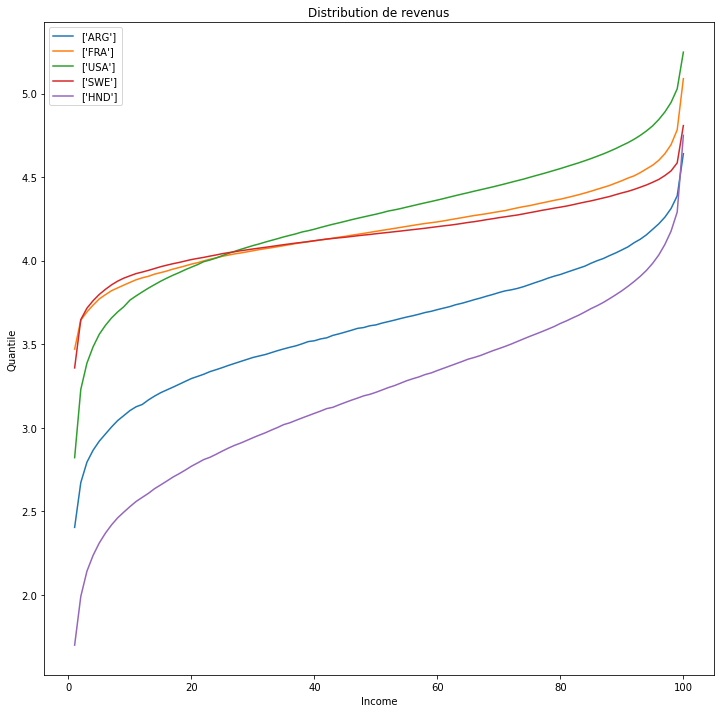

In [58]:
plt.figure(figsize =(12, 12))
for i in dico_5_pays:
    plt.plot(dico_5_pays[i]['quantile'], np.log10(dico_5_pays[i]['income']), label=dico_5_pays[i]['country'].unique())

plt.title('Distribution de revenus')
plt.xlabel('Income')
plt.ylabel('Quantile')
plt.legend()
#plt.savefig('distribution_revenus.png')
plt.show()

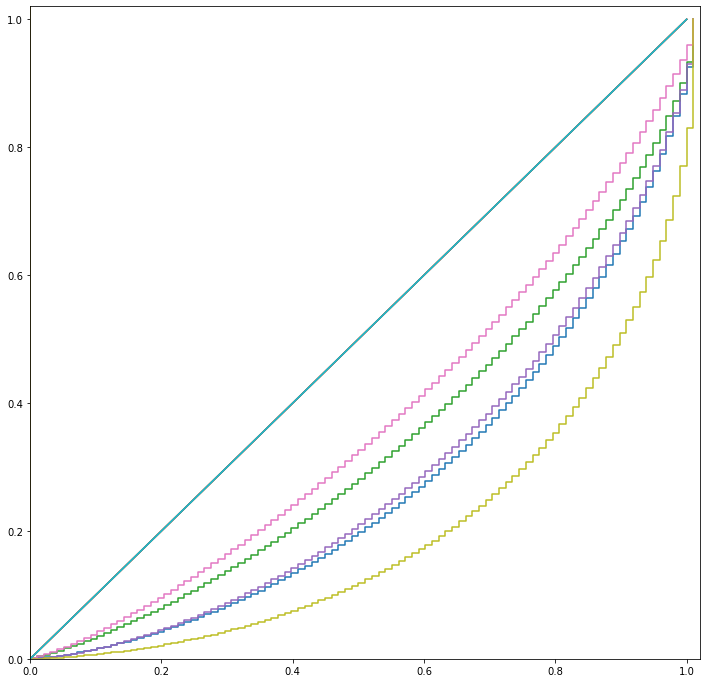

In [59]:
#reprise de la courbe de lorenz du cours d'OC

#il faut trier les individus dans l'ordre croissant des valeurs de la variable
#Pour normaliser et faire en sorte que le haut de la courbe soit à 1, 
#on divise le tout par dep.sum()

plt.figure(figsize =(12, 12))
plt.axis([0, 1.02, 0, 1.02])
for i in dico_5_pays:
    income = dico_5_pays[i]['income'].values
    n = len(income)
    lorenz = np.cumsum(np.sort(income)) / income.sum()
    lorenz = np.append([i],lorenz) # La courbe de Lorenz commence à 0

    xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.plot([0,1], [0,1])
plt.show()

In [60]:
#Je crée le dictionnaire qui permet

df_pov_gini_melted_sans_NaN.sort_values(by='year_survey',inplace=True)

#choix des pays pour les indices de Gini. ARG, FRA, USA, SWE, HND
df_5_pays = ['ARG', 'FRA', 'USA', 'SWE', 'HND']

dico_5_pays = {}
k = 0
while k < 5:
    key = k
    # calculate value
    value = df_pov_gini_melted_sans_NaN[df_pov_gini_melted_sans_NaN['country'] == df_5_pays[k]]
    dico_5_pays[key] = value
    k += 1

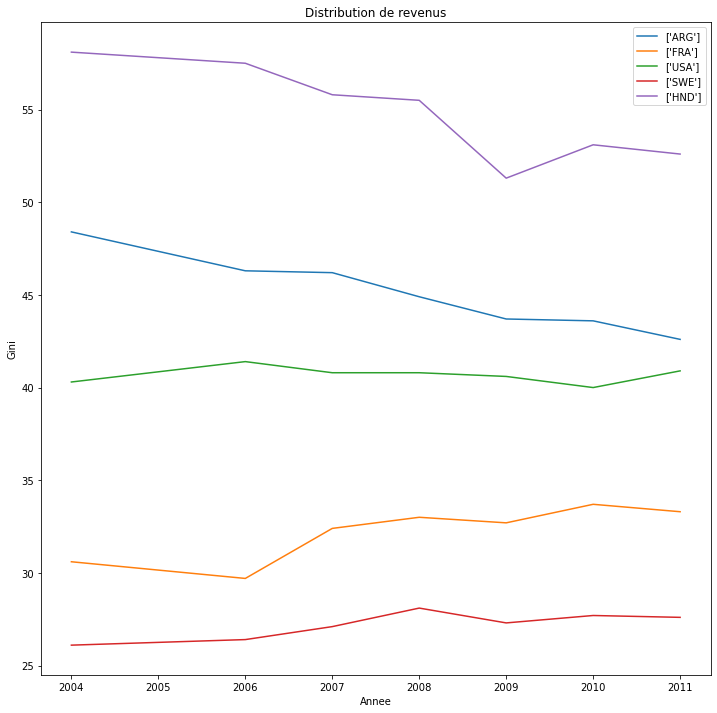

In [61]:
plt.figure(figsize =(12, 12))
for i in dico_5_pays:
    #data748 = dico_5_pays[dico_10_pays[i]['country'] == x]
    plt.plot(dico_5_pays[i]['year_survey'], (dico_5_pays[i]['Gini']), label=dico_5_pays[i]['country'].unique())

plt.title('Distribution de revenus')
plt.xlabel('Annee')
plt.ylabel('Gini')
plt.legend()
#plt.savefig('distribution_revenus.png')
plt.show()

Ici on voit l'évolution de l'indice de Gini de chaque pays. L'indice baisse pour chaque pays ce qui signifie que les inégalites se tassent, sauf pour la France où il est en légère augmentation. L'indice de Gini de la Suède augmente lui aussi mais c'est moins significatif. Seuls les USA ont une courbe plate.

# Mission 3

Dans l'état actuel, nous avons à disposition deux des trois variables explicatives souhaitées :
le revenu moyen du pays mj, 
l'indice de Gini du pays GJ.
Il nous manque donc, pour un individu , la classe de revenu de ses parents.
Nous allons donc simuler cette information grâce à un coefficient (propre à chaque pays )
mesurant une corrélation entre le revenu de l'individu et le revenu de ses parents. Ce coefficient
sera ici appelé coefficient d'élasticité., il mesure la mobilité intergénérationnelle du revenu.


Un exemple de code permettant de réaliser les opérations 1 à 6 est donné tout en bas. Libre à
vous de l'utiliser. Notamment, la fonction proba_cond vous donnera les probabilités
P(c | , j) . 

In [62]:
import scipy.stats as st
from collections import Counter

def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)
    
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()
    
def proba_cond(c_i_parent, c_i_child, mat):
    #return mat[c_i_child, c_i_parent]
    return mat[c_i_child-1, c_i_parent-1]

pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
#plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10
print(cd)

c_i_child = 5 
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

[[0.229 0.12  0.1   ... 0.    0.    0.   ]
 [0.137 0.08  0.084 ... 0.    0.    0.   ]
 [0.083 0.067 0.067 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.064 0.065 0.083]
 [0.    0.    0.    ... 0.08  0.079 0.119]
 [0.    0.    0.    ... 0.079 0.115 0.256]]

P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.035


## Intégration de l'élasticité

In [63]:
#mj revenu moyen du pays
#Gj indice de Gini du pays
#il nous manque la classe de revenu ci_parent de de ses parents
#=> 1 individu => 1 seule classe ci_parent
#pj corrélation entre le revenu de l'individu et
#le revenu de ses parents. > coeff d'elasticité.
#mesure la mobilité intergénérationnelle du revenu.


In [64]:
txt_elasticity = pd.read_table('elasticity.txt')

txt_elasticity

,Coefficients of intergenerational elasticity between parents’ and
0,children’s income
1,| Base case | Optim...
2,| | (high...
3,----------------------------------------------...
4,Nordic European countries | 0.2 | ...
5,and Canada | | ...
6,----------------------------------------------...
7,Europe (except nordic | 0.4 | ...
8,countries) | | ...
9,----------------------------------------------...


In [65]:
df_gdim = pd.read_csv('GDIMMay2018+.csv')
df_gdim.drop_duplicates(inplace=True)
df_gdim

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.10
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.10
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.10
3,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25396.0,0.050447,18387.0,0.218062,NaN,NaN,NaN,NaN,0.10
4,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12246.0,0.047961,8677.0,0.230909,NaN,NaN,NaN,NaN,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,1830.0,0.023843,980.0,0.069934,NaN,NaN,NaN,NaN,0.16
6500,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,1948.0,0.010193,912.0,0.098336,NaN,NaN,NaN,NaN,0.16
6501,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,4375.0,0.016527,2269.0,0.072795,NaN,NaN,NaN,NaN,0.16
6502,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,2109.0,0.011469,1183.0,0.088865,NaN,NaN,NaN,NaN,0.16


In [66]:
df_gdim.rename(columns={'countryname':'Area', 'iso3':'country'},inplace=True)
df_gdim = df_gdim[['country', 'Area', 'region', 'year', 'IGEincome']]
#df_gdim.dropna(inplace=True)
df_gdim

,country,Area,region,year,IGEincome
0,AFG,Afghanistan,South Asia,1980,NaN
1,AFG,Afghanistan,South Asia,1980,NaN
2,AFG,Afghanistan,South Asia,1980,NaN
3,AFG,Afghanistan,South Asia,1980,NaN
4,AFG,Afghanistan,South Asia,1980,NaN
...,...,...,...,...,...
6499,ZMB,Zambia,Sub-Saharan Africa,1980,NaN
6500,ZMB,Zambia,Sub-Saharan Africa,1980,NaN
6501,ZMB,Zambia,Sub-Saharan Africa,1980,NaN
6502,ZMB,Zambia,Sub-Saharan Africa,1980,NaN


In [67]:
#Nordic European countries |    0.2     |      0.15      |    0.3
#and Canada                |            |                |
#---------------------------------------------------------------------------
#Europe (except nordic     |    0.4     |      0.3       |    0.5
#countries)                |            |                |
#---------------------------------------------------------------------------
#Australia/New Zealand/USA |    0.4     |      0.3       |    0.5
#---------------------------------------------------------------------------
#Asia                      |    0.5     |      0.4       |    0.6
#---------------------------------------------------------------------------
#Latin America/Africa      |    0.66    |      0.5       |    0.9

In [68]:
df_gdim['region'].unique()

array(['South Asia', 'Sub-Saharan Africa', 'Europe & Central Asia',
       'Latin America & Caribbean', 'High income', 'East Asia & Pacific',
       'Middle East & North Africa'], dtype=object)

In [69]:
df_gdim[df_gdim['region']=='High income'].groupby(['country']).mean().reset_index()['country'].unique()

array(['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'CHL', 'CYP', 'CZE', 'DEU',
       'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN',
       'IRL', 'ISL', 'ISR', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA',
       'NLD', 'NOR', 'NZL', 'POL', 'PRT', 'SGP', 'SVK', 'SVN', 'SWE',
       'TWN', 'URY', 'USA'], dtype=object)

In [70]:
df_gdim

,country,Area,region,year,IGEincome
0,AFG,Afghanistan,South Asia,1980,NaN
1,AFG,Afghanistan,South Asia,1980,NaN
2,AFG,Afghanistan,South Asia,1980,NaN
3,AFG,Afghanistan,South Asia,1980,NaN
4,AFG,Afghanistan,South Asia,1980,NaN
...,...,...,...,...,...
6499,ZMB,Zambia,Sub-Saharan Africa,1980,NaN
6500,ZMB,Zambia,Sub-Saharan Africa,1980,NaN
6501,ZMB,Zambia,Sub-Saharan Africa,1980,NaN
6502,ZMB,Zambia,Sub-Saharan Africa,1980,NaN


In [71]:
#Il manque le Kosvo et la Syrie. Je les ajoute. On leur met arbitrairement l'année 1980 pour davantage de facilité plus tard.
df_tempo = pd.DataFrame({'country': ['SYR','XKX'], 'region': ['Middle East & North Africa', 'Europe & Central Asia'],'year':[1980, 1980]})
df_gdim = pd.concat([df_gdim, df_tempo]).reset_index(drop=True)
df_gdim

,country,Area,region,year,IGEincome
0,AFG,Afghanistan,South Asia,1980,NaN
1,AFG,Afghanistan,South Asia,1980,NaN
2,AFG,Afghanistan,South Asia,1980,NaN
3,AFG,Afghanistan,South Asia,1980,NaN
4,AFG,Afghanistan,South Asia,1980,NaN
...,...,...,...,...,...
6501,ZMB,Zambia,Sub-Saharan Africa,1980,NaN
6502,ZMB,Zambia,Sub-Saharan Africa,1980,NaN
6503,ZMB,Zambia,Sub-Saharan Africa,1980,NaN
6504,SYR,NaN,Middle East & North Africa,1980,NaN


In [72]:
#je dois completer l'IGEincome des pays qui n'en ont pas.
#Pour cela je dois m'aider des regions du df_gdim.    

mask = (df_gdim['region']=='South Asia')
df_gdim['IGEincome'] = df_gdim['IGEincome'].mask(mask, df_gdim['IGEincome'].fillna(0.5))

mask = (df_gdim['region']=='Sub-Saharan Africa')
df_gdim['IGEincome'] = df_gdim['IGEincome'].mask(mask, df_gdim['IGEincome'].fillna(0.66))

mask = (df_gdim['region']=='Europe & Central Asia')
df_gdim['IGEincome'] = df_gdim['IGEincome'].mask(mask, df_gdim['IGEincome'].fillna(0.4))

mask = (df_gdim['region']=='Latin America & Caribbean')
df_gdim['IGEincome'] = df_gdim['IGEincome'].mask(mask, df_gdim['IGEincome'].fillna(0.66))

mask = (df_gdim['region']=='East Asia & Pacific')
df_gdim['IGEincome'] = df_gdim['IGEincome'].mask(mask, df_gdim['IGEincome'].fillna(0.5))

mask = (df_gdim['region']=='Middle East & North Africa')
df_gdim['IGEincome'] = df_gdim['IGEincome'].mask(mask, df_gdim['IGEincome'].fillna(0.5))

mask = (df_gdim['region']=='High income')
df_gdim['IGEincome'] = df_gdim['IGEincome'].mask(mask, df_gdim['IGEincome'].fillna(0.3))

In [73]:
df_gdim = df_gdim.rename(columns={'IGEincome':'IGEincome_pj'})
df_gdim.sample(4)

,country,Area,region,year,IGEincome_pj
1103,COL,Colombia,Latin America & Caribbean,1940,0.66
4648,NZL,New Zealand,High income,1970,0.29
2975,JPN,Japan,High income,1960,0.34
1520,ECU,Ecuador,Latin America & Caribbean,1940,0.66


In [74]:
df_datap7_Gini.sample(4)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value,Gini
2886,EGY,2009,87,100,2866.3098,5011.0000,"Egypt, Arab Rep.",79636079.0,33.059168
6623,MDA,2008,24,100,1246.3900,2768.0000,Moldova,4112891.0,34.700000
7493,MRT,2008,94,100,4087.4775,2226.7344,Mauritania,3296238.0,35.700000
3773,GIN,2007,74,100,813.1530,977.0000,Guinea,9738792.0,39.400000


In [75]:
df_gdim_2 = df_gdim.loc[df_gdim['year'] == 1980].reset_index(drop=True)

In [76]:
#On y ajoute le luxembourg, année 1960
df_gdim_2 = pd.concat([df_gdim_2, df_gdim.loc[df_gdim['country']=='LUX']]).reset_index(drop=True)
df_gdim_2

,country,Area,region,year,IGEincome_pj
0,AFG,Afghanistan,South Asia,1980,0.500000
1,AFG,Afghanistan,South Asia,1980,0.500000
2,AFG,Afghanistan,South Asia,1980,0.500000
3,AFG,Afghanistan,South Asia,1980,0.500000
4,AFG,Afghanistan,South Asia,1980,0.500000
...,...,...,...,...,...
1659,ZMB,Zambia,Sub-Saharan Africa,1980,0.660000
1660,ZMB,Zambia,Sub-Saharan Africa,1980,0.660000
1661,SYR,NaN,Middle East & North Africa,1980,0.500000
1662,XKX,NaN,Europe & Central Asia,1980,0.400000


In [77]:
test_is_null(df_gdim)

Test de chaque variable avec isnull
country         0
Area            2
region          0
year            0
IGEincome_pj    0
dtype: int64
___


In [78]:
df_gdim = df_gdim.groupby(by=['country']).mean().reset_index()

In [79]:
df_datap7_Gini

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Area,Value,Gini
0,ALB,2008,1,100,728.89795,7297.00000,Albania,3002678.0,30.000000
1,ALB,2008,2,100,916.66235,7297.00000,Albania,3002678.0,30.000000
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,3002678.0,30.000000
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,3002678.0,30.000000
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,3002678.0,30.000000
...,...,...,...,...,...,...,...,...,...
11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754
11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754
11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754
11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754


In [80]:
#il ne faudrait garder que l'année 1980
df_datap7_Gini_elasticity = pd.merge(df_datap7_Gini, df_gdim, how='left', indicator=True)
df_datap7_Gini_elasticity.drop(columns=['nb_quantiles','year','_merge'], inplace=True)
df_datap7_Gini_elasticity

,country,year_survey,quantile,income,gdpppp,Area,Value,Gini,IGEincome_pj
0,ALB,2008,1,728.89795,7297.00000,Albania,3002678.0,30.000000,0.483175
1,ALB,2008,2,916.66235,7297.00000,Albania,3002678.0,30.000000,0.483175
2,ALB,2008,3,1010.91600,7297.00000,Albania,3002678.0,30.000000,0.483175
3,ALB,2008,4,1086.90780,7297.00000,Albania,3002678.0,30.000000,0.483175
4,ALB,2008,5,1132.69970,7297.00000,Albania,3002678.0,30.000000,0.483175
...,...,...,...,...,...,...,...,...,...
11595,COD,2008,96,810.62330,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754,0.669540
11596,COD,2008,97,911.78340,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754,0.669540
11597,COD,2008,98,1057.80740,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754,0.669540
11598,COD,2008,99,1286.60290,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754,0.669540


## On a enfin terminé le travail sur le dataframe. On peut passer aux questions

Ici on a un modèle de machine learning. Cela prédit soit un chiffre dans le cas des algos de regression, ou une catégorie dans le cas des algos de classification. Là on a une colonne Y que l'on veut prédire à partir d'autres colonnes. Ici on a 3 variables explicatives. Le revenu du pays, l'indice de Gini et la classe des parents. Ici l'idée est de trouver la 3e variable explicative manquante.


### 1. Générez un grand nombre n de réalisations d'une variable que nous appellerons ln(Yparent) selon une loi normale. Le choix de la moyenne et de l'écart-type n'auront pas d'incidence sur le résultat final doit être supérieur à 1000 fois le nombre de quantiles.

In [81]:
#Pour la question 1 et 2 on utilise les lignes de la fonction generate incomes
def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

In [82]:
#pj de la France

pj = df_datap7_Gini_elasticity.loc[df_datap7_Gini_elasticity['country'].isin(['FRA']), 'IGEincome_pj'].unique()
pj = pj[0]
print('Le pj de la France est {}'.format(pj))

Le pj de la France est 0.31142102


In [83]:
#n doit être supérieur à 1000 fois le nombre de quantiles. On a 100 quantiles. On choisi 1000. Donc n=100 000
n = 100000

#utilisation des calculs dans la fonction generate incomes
ln_y_parent = st.norm(0,1).rvs(size=n)
ln_y_parent

array([ 0.04342701, -0.07050886, -0.49052117, ...,  1.75903106,
       -0.41647556, -0.97354491])

### Générez réalisations du terme d'erreur selon une loi normale de moyenne 0 et d'écart-type 1

In [84]:
residues = st.norm(0,1).rvs(size=n)
residues

array([-1.28537885, -0.5353194 ,  0.13147911, ..., -2.01715192,
       -0.8856663 ,  0.5554893 ])

###  Pour une valeur donnée de (par exemple 0.9), calculez . Le choix den'a aucune incidence sur le résultat final et peut être supprimé. A ce stade, contient des valeurs dont l'ordre de grandeur ne reflète pas la réalité, mais cela n'a pas d'influence pour la suite.

In [85]:
#je calcule y child en même temps que y_parent dans la question suivante car bug sinon.

### Pour chacun des individus générés, calculez la classe de revenu ainsi que la classe de revenu de ses parents C_i_parent , à partir de Ychild et Yparent.

In [86]:
n = 100000
#pj = pj de la France, soit 0.31142102
y_child = generate_incomes(n, pj)

In [87]:
y_child, y_parent = generate_incomes(n, pj)

In [88]:
#Pourquoi séparé ça ne marche pas mais calculés ensemble ça fonctionne ?

#y_parent = generate_incomes(n, pj)
#y_child = generate_incomes(n, pj)

In [89]:
#classe de revenus:
sample2 = compute_quantiles(y_child, y_parents, nb_quantiles)
sample2

,y_child,y_parents,c_i_child,c_i_parent
0,0.094281,1.399875,2,63
1,0.252915,0.339537,10,14
2,1.274930,2.350236,60,81
3,2.564370,2.050962,82,77
4,1.585956,0.222928,68,7
...,...,...,...,...
99995,0.686617,0.712071,36,37
99996,4.174641,4.308948,92,93
99997,1.070529,0.382407,53,17
99998,1.436305,2.449854,64,82


In [90]:
n1=100
y_child, y_parent = generate_incomes(n1, pj)
sample_test = compute_quantiles(y_child, y_parents, 100)
sample_test = sample_test.head(100)
sample_test.sort_values('c_i_parent', ascending=False)

,y_child,y_parents,c_i_child,c_i_parent
24,0.369774,14.109278,15.0,100
54,0.093163,8.067855,1.0,99
53,1.895948,7.509098,69.0,98
63,0.541230,5.873603,27.0,97
77,2.090685,4.497652,73.0,94
...,...,...,...,...
20,0.531104,0.138160,25.0,3
31,0.273052,0.126285,10.0,2
94,0.981690,0.092391,52.0,1
13,3.613251,0.076481,87.0,1


## A partir de cette dernière information, estimez pour chaque la distribution conditionnelle de C_i_parent.

In [91]:
distribution_conditionnelle = conditional_distributions(sample2, nb_quantiles)
distribution_conditionnelle

array([[0.003, 0.007, 0.008, ..., 0.006, 0.006, 0.013],
       [0.013, 0.008, 0.006, ..., 0.011, 0.014, 0.014],
       [0.006, 0.017, 0.009, ..., 0.006, 0.011, 0.008],
       ...,
       [0.008, 0.006, 0.009, ..., 0.009, 0.007, 0.007],
       [0.013, 0.009, 0.014, ..., 0.011, 0.009, 0.011],
       [0.014, 0.005, 0.01 , ..., 0.011, 0.006, 0.016]])

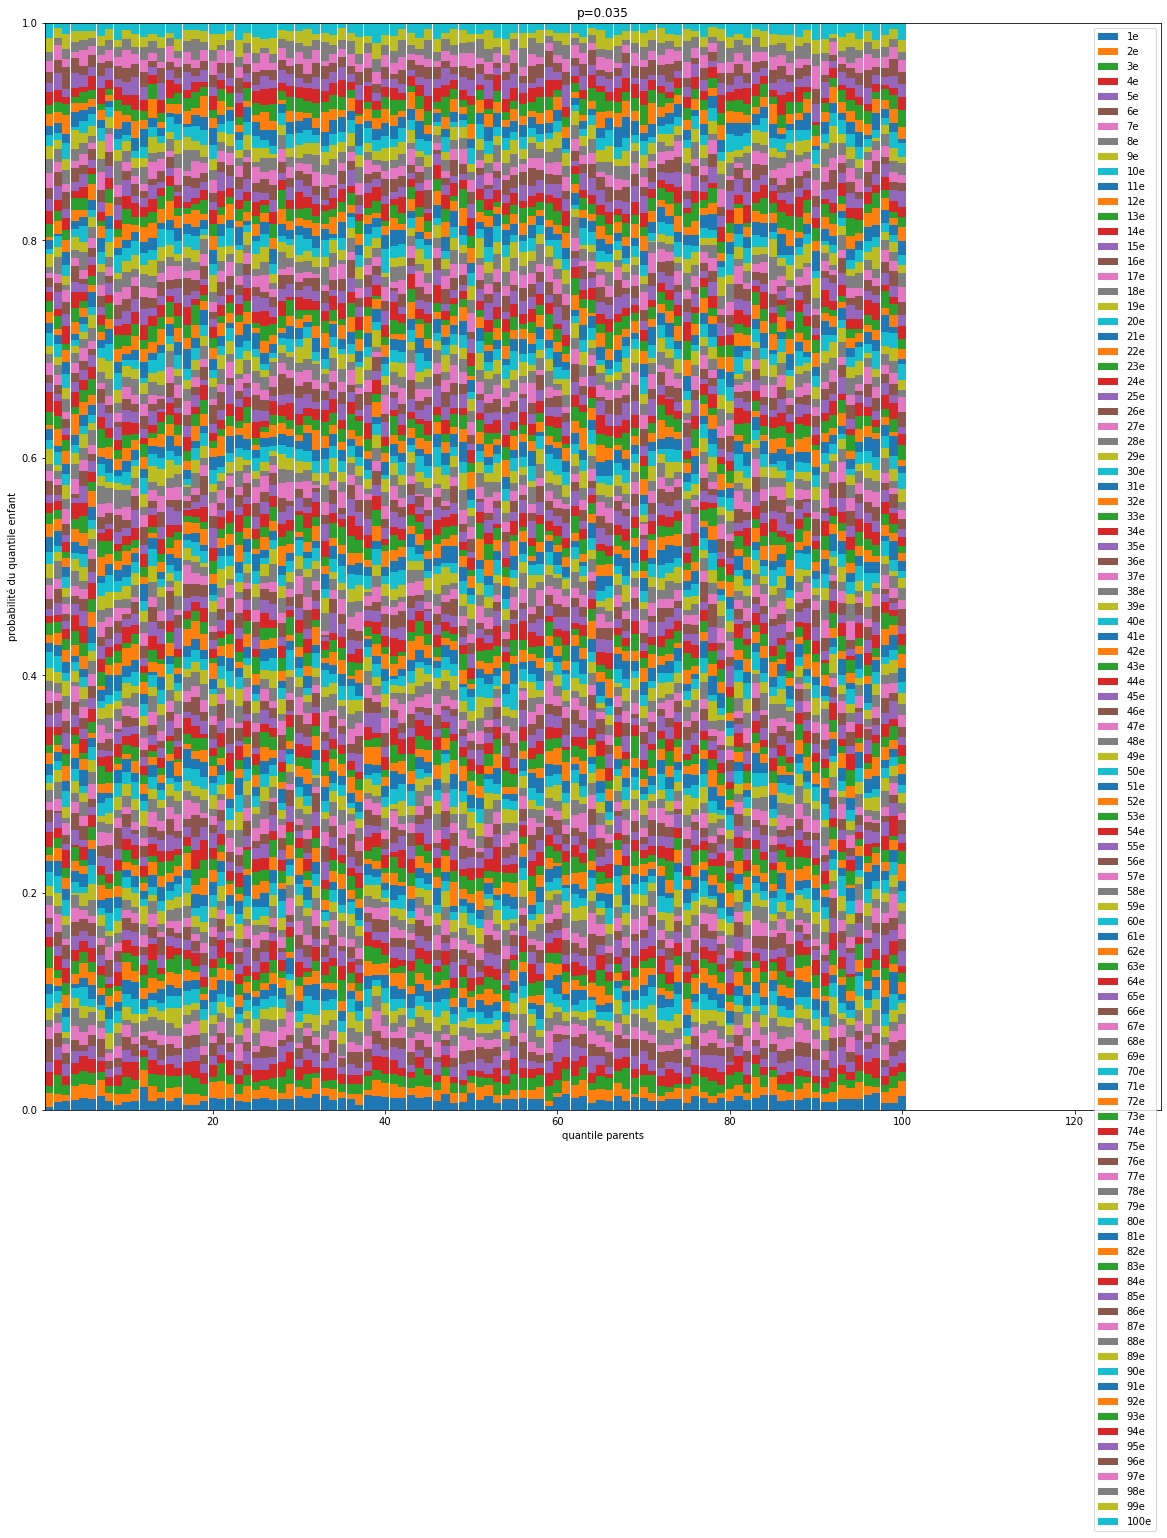

In [92]:
plt.rcParams['figure.figsize'] = [20,20]
plot_conditional_distributions(p, distribution_conditionnelle, nb_quantiles)

On peut observer ici une forte mobilité intergénérationnelle.

## Nous allons maintenant travailler sur un nouvel échantillon. Celui-ci sera créé à partir de la WID. Pour chaque individu de la Wold Income Distribution, créez-en 499 "clones". La taille de votre nouvel échantillon sera donc 500 fois plus grand que celui de la Wold Income Distribution.

In [93]:
#https://stackoverflow.com/questions/23887881/how-to-repeat-a-pandas-dataframe

In [94]:
import time

start = time.time()
end = time.time()
print(end - start)

0.0


In [95]:
start = time.time()

df_500 = pd.concat([df_datap7_Gini_elasticity]*500, ignore_index=True)
df_500

end = time.time()
print(end - start)

0.4069652557373047


In [96]:
df_500.shape

(5800000, 9)

In [97]:
df_datap7_Gini_elasticity

,country,year_survey,quantile,income,gdpppp,Area,Value,Gini,IGEincome_pj
0,ALB,2008,1,728.89795,7297.00000,Albania,3002678.0,30.000000,0.483175
1,ALB,2008,2,916.66235,7297.00000,Albania,3002678.0,30.000000,0.483175
2,ALB,2008,3,1010.91600,7297.00000,Albania,3002678.0,30.000000,0.483175
3,ALB,2008,4,1086.90780,7297.00000,Albania,3002678.0,30.000000,0.483175
4,ALB,2008,5,1132.69970,7297.00000,Albania,3002678.0,30.000000,0.483175
...,...,...,...,...,...,...,...,...,...
11595,COD,2008,96,810.62330,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754,0.669540
11596,COD,2008,97,911.78340,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754,0.669540
11597,COD,2008,98,1057.80740,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754,0.669540
11598,COD,2008,99,1286.60290,303.19305,"Congo, Dem. Rep.",60411195.0,44.400754,0.669540


Ennoncé : Pour chaque Ci_child et chaque pays, il y a maintenant 500 individus. Vous attribuerez aux 500 individus leurs classes conformément aux distributions trouvées précédemment. 

In [98]:
## On reprend à partir de là

In [99]:
df_datap7_Gini_elasticity_boucle = df_datap7_Gini_elasticity.copy()
df_datap7_Gini_elasticity_boucle = df_datap7_Gini_elasticity_boucle[['country', 'quantile', 'income', 'Gini', 'IGEincome_pj']]
df_datap7_Gini_elasticity_boucle.rename(columns={'income':'y_child', 'quantile':'c_i_child', 'Gini':'Gj'}, inplace=True)
df_datap7_Gini_elasticity_boucle

,country,c_i_child,y_child,Gj,IGEincome_pj
0,ALB,1,728.89795,30.000000,0.483175
1,ALB,2,916.66235,30.000000,0.483175
2,ALB,3,1010.91600,30.000000,0.483175
3,ALB,4,1086.90780,30.000000,0.483175
4,ALB,5,1132.69970,30.000000,0.483175
...,...,...,...,...,...
11595,COD,96,810.62330,44.400754,0.669540
11596,COD,97,911.78340,44.400754,0.669540
11597,COD,98,1057.80740,44.400754,0.669540
11598,COD,99,1286.60290,44.400754,0.669540


In [100]:
import scipy.stats as st
import pandas as pd
import numpy as np
from collections import Counter

def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)
    
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()
    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
#plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10
print(cd)

c_i_child = 5 
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

[[0.226 0.113 0.093 ... 0.    0.    0.   ]
 [0.118 0.091 0.065 ... 0.    0.    0.   ]
 [0.091 0.067 0.058 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.053 0.074 0.086]
 [0.    0.    0.    ... 0.076 0.095 0.121]
 [0.    0.    0.    ... 0.086 0.118 0.251]]

P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.019


In [101]:
import random
import time
import sys

In [102]:
#  Définition des paramètres
nb_quantiles = 10
n = 1000 * nb_quantiles
pj = 0.9

# Génération selon la loi Normale
ln_y_parent = st.norm(0,1).rvs(size=n)
residus = st.norm(0,1).rvs(size=n)

# Calcul des revenus des parents et des enfants
y_child = np.exp(pj * ln_y_parent + residus)
y_parents = np.exp(ln_y_parent)

# Conversion des tableaux en series
y_child = pd.Series(y_child)
y_parents = pd.Series(y_parents)

# Détermination de la classe de revenus des enfants
size_child = len(y_child)

l_sorted_child = y_child.copy()
l_sorted_child = l_sorted_child.sort_values()
quantiles_child = np.round(np.arange(1,
                                     nb_quantiles + 1,
                                     nb_quantiles / size_child) - 0.5 + 1./size_child)
q_dict_child = {a: int(b) for a, b in zip(l_sorted_child, quantiles_child)}
c_i_child = pd.Series(q_dict_child[e] for e in  y_child)

# Détermination de la classe de revenus des parents
size_parents = len(y_parents)
l_sorted_parents = y_parents.copy()
l_sorted_parents = l_sorted_parents.sort_values()
quantiles_parents = np.round(np.arange(1,
                                       nb_quantiles + 1,
                                       nb_quantiles / size_parents) - 0.5 + 1./size_parents)
q_dict_parents = {a: int(b) for a, b in zip(l_sorted_parents, quantiles_parents)}
c_i_parent = pd.Series(q_dict_parents[e] for e in  y_parents)

# Mise en forme
sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis = 1)
sample.columns = ['y_child', 'y_parents', 'c_i_child', 'c_i_parent']


In [103]:
start = time.time()

pays_list=df_datap7_Gini_elasticity_boucle['country'].unique()
classe_parent=0
classe_enfant=0
list_prob=[]

for pays in pays_list:
    pj=df_datap7_Gini_elasticity_boucle.loc[df_datap7_Gini_elasticity_boucle['country']==pays,'IGEincome_pj'].iloc[0]
    nb_quantiles = 100 # nombre de quantiles (nombre de classes de revenu)
    n = 50000 # taille de l'échantillon
    y_child, y_parents = generate_incomes(n, pj)
    sample = compute_quantiles(y_child, y_parents, nb_quantiles)
    cd = conditional_distributions(sample, nb_quantiles)
    for c_i_child in range(100):
        for c_i_parent in range(100):
            p = proba_cond(c_i_parent, c_i_child, cd)
            list_prob.extend([c_i_parent+1]*(int(p*500)))
            


In [104]:
print("Temps d'exécution: ", time.time() - start)

Temps d'exécution:  186.84281659126282


In [105]:
len(list_prob)

5800000

In [106]:
df_500_datap7_Gini_elasticity_boucle = pd.concat([df_datap7_Gini_elasticity_boucle]*500, ignore_index=True)

In [107]:
df_500_datap7_Gini_elasticity_boucle.shape

(5800000, 5)

In [108]:
df_500_datap7_Gini_elasticity_boucle['proba']=list_prob

In [109]:
df_500_datap7_Gini_elasticity_boucle

,country,c_i_child,y_child,Gj,IGEincome_pj,proba
0,ALB,1,728.89795,30.000000,0.483175,1
1,ALB,2,916.66235,30.000000,0.483175,1
2,ALB,3,1010.91600,30.000000,0.483175,1
3,ALB,4,1086.90780,30.000000,0.483175,1
4,ALB,5,1132.69970,30.000000,0.483175,1
...,...,...,...,...,...,...
5799995,COD,96,810.62330,44.400754,0.669540,100
5799996,COD,97,911.78340,44.400754,0.669540,100
5799997,COD,98,1057.80740,44.400754,0.669540,100
5799998,COD,99,1286.60290,44.400754,0.669540,100


# Mission 4 : nous chercherons à expliquer le revenu des individus en fonction de plusieurs variables explicatives : le pays de l'individu, l'indice de Gini de ce pays, la classe de revenus des parents, etc

Pour cette mission 4, nous chercherons à expliquer le revenu des individus en fonction de plusieurs
variables explicatives : le pays de l'individu, l'indice de Gini de ce pays, la classe de revenus des
parents, etc.

In [110]:
#https://www.reneshbedre.com/blog/anova.html

In [111]:
df_500_datap7_Gini_elasticity_boucle

,country,c_i_child,y_child,Gj,IGEincome_pj,proba
0,ALB,1,728.89795,30.000000,0.483175,1
1,ALB,2,916.66235,30.000000,0.483175,1
2,ALB,3,1010.91600,30.000000,0.483175,1
3,ALB,4,1086.90780,30.000000,0.483175,1
4,ALB,5,1132.69970,30.000000,0.483175,1
...,...,...,...,...,...,...
5799995,COD,96,810.62330,44.400754,0.669540,100
5799996,COD,97,911.78340,44.400754,0.669540,100
5799997,COD,98,1057.80740,44.400754,0.669540,100
5799998,COD,99,1286.60290,44.400754,0.669540,100


In [112]:
#meme boucle qu'au dessus mais avec mes données x500 calculées en fin de mission 3
df_500_datap7_Gini_elasticity_boucle_moyen = df_500_datap7_Gini_elasticity_boucle.copy()
df_500_datap7_Gini_elasticity_boucle_moyen = df_500_datap7_Gini_elasticity_boucle_moyen.groupby(['country']).mean().reset_index()
df_500_datap7_Gini_elasticity_boucle_moyen.rename(columns={'y_child':'income_moyen'}, inplace=True)
df_500_datap7_Gini_elasticity_boucle_moyen = df_500_datap7_Gini_elasticity_boucle_moyen[['country', 'income_moyen']]
df_500_datap7_Gini_elasticity_boucle_moyen = pd.merge(df_500_datap7_Gini_elasticity_boucle, df_500_datap7_Gini_elasticity_boucle_moyen, how='inner')
df_500_datap7_Gini_elasticity_boucle_moyen.rename(columns={'Gj':'indice', 'y_child':'income'}, inplace=True)
#df_500_datap7_Gini_elasticity_boucle_moyen['indice'] = df_500_datap7_Gini_elasticity_boucle_moyen['indice']/100
df_500_datap7_Gini_elasticity_boucle_moyen

,country,c_i_child,income,indice,IGEincome_pj,proba,income_moyen
0,ALB,1,728.89795,30.000000,0.483175,1,2994.829902
1,ALB,2,916.66235,30.000000,0.483175,1,2994.829902
2,ALB,3,1010.91600,30.000000,0.483175,1,2994.829902
3,ALB,4,1086.90780,30.000000,0.483175,1,2994.829902
4,ALB,5,1132.69970,30.000000,0.483175,1,2994.829902
...,...,...,...,...,...,...,...
5799995,COD,96,810.62330,44.400754,0.669540,100,276.016044
5799996,COD,97,911.78340,44.400754,0.669540,100,276.016044
5799997,COD,98,1057.80740,44.400754,0.669540,100,276.016044
5799998,COD,99,1286.60290,44.400754,0.669540,100,276.016044


In [113]:
#df_datap7_Gini_elasticity

In [114]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
df_500_datap7_Gini_elasticity_boucle_moyen["income"] = df_500_datap7_Gini_elasticity_boucle_moyen["income"].astype(float)
import statsmodels.api as sm
import statsmodels.formula.api as smf
df_500_datap7_Gini_elasticity_boucle_moyen["income"] = df_500_datap7_Gini_elasticity_boucle_moyen["income"].astype(float)
anova2 = df_500_datap7_Gini_elasticity_boucle_moyen.copy()
anova2["income"] = np.log(anova2["income"])

(array([5.16232215e-05, 3.98601050e-06, 6.43219298e-07, 1.41313331e-07,
        5.84744816e-08, 3.41101143e-08, 1.94914939e-08, 4.87287347e-09,
        4.87287347e-09, 9.74574694e-09]),
 array([1.67194180e+01, 1.77079025e+04, 3.53990855e+04, 5.30902686e+04,
        7.07814517e+04, 8.84726347e+04, 1.06163818e+05, 1.23855001e+05,
        1.41546184e+05, 1.59237367e+05, 1.76928550e+05]),
 <BarContainer object of 10 artists>)

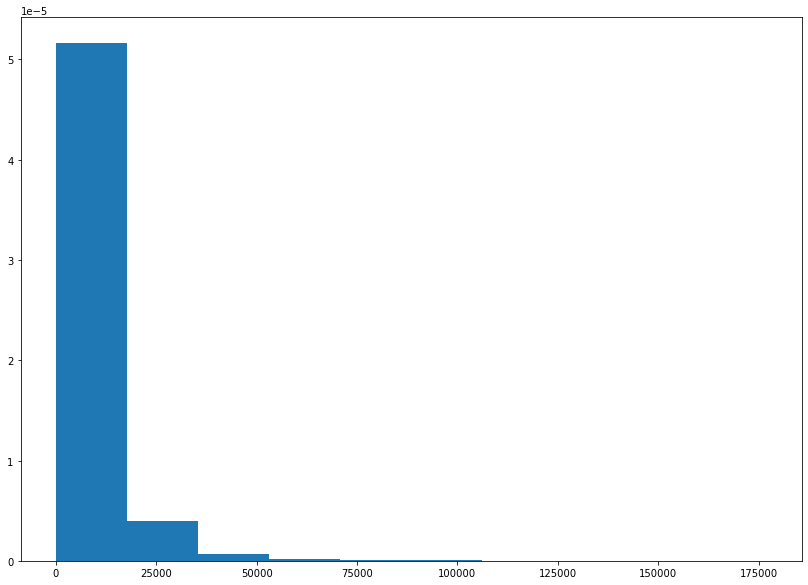

In [115]:
T = df_500_datap7_Gini_elasticity_boucle_moyen["income"]
plt.rcParams['figure.figsize'] = [14,10]
plt.hist(T, density=True)

(array([0.00102329, 0.00651185, 0.03990832, 0.15256326, 0.24810135,
        0.23824055, 0.20158816, 0.1573076 , 0.03134989, 0.00251171]),
 array([ 2.8165708 ,  3.74326384,  4.66995689,  5.59664994,  6.52334298,
         7.45003603,  8.37672907,  9.30342212, 10.23011517, 11.15680821,
        12.08350126]),
 <BarContainer object of 10 artists>)

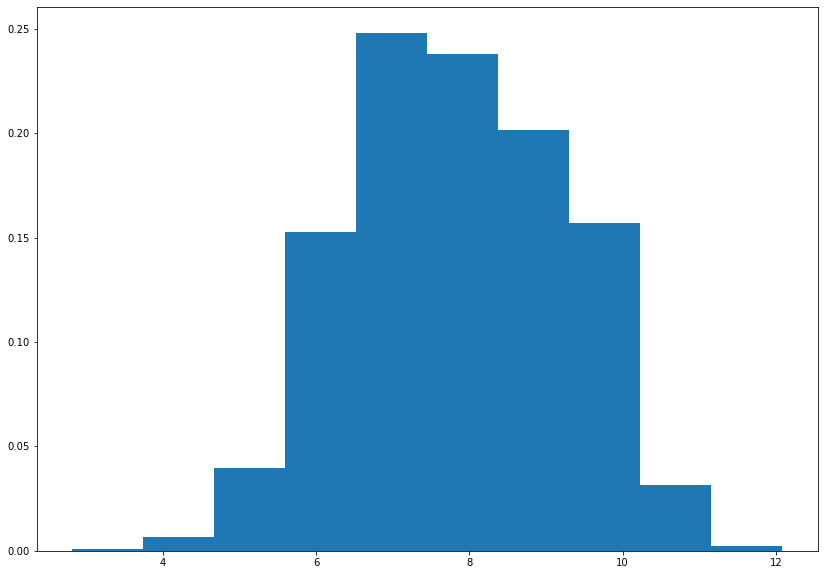

In [116]:
#Valeurs en log

X = anova2["income"]
plt.rcParams['figure.figsize'] = [14,10]
plt.hist(X, density=True)

In [117]:
from scipy.stats import shapiro
pval = shapiro(T)
pval2 = shapiro(X)
print(pval)
print(pval2)

C:\Users\jb-14\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.6011691093444824, pvalue=0.0)
ShapiroResult(statistic=0.9893906116485596, pvalue=0.0)


Le tableau ANOVA représente les sources de variation entre les groupes et au sein des groupes, ainsi que les degrés de liberté qui leur sont associés, la somme des carrés (SS) et les carrés moyens (MS). La variation totale est la somme des variances entre et au sein du groupe. La valeur F est un rapport des carrés moyens (MS) entre et au sein du groupe. La valeur p est estimée à partir de la valeur F et du degré de liberté.

https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas

In [118]:
df_500_datap7_Gini_elasticity_boucle_moyen

,country,c_i_child,income,indice,IGEincome_pj,proba,income_moyen
0,ALB,1,728.89795,30.000000,0.483175,1,2994.829902
1,ALB,2,916.66235,30.000000,0.483175,1,2994.829902
2,ALB,3,1010.91600,30.000000,0.483175,1,2994.829902
3,ALB,4,1086.90780,30.000000,0.483175,1,2994.829902
4,ALB,5,1132.69970,30.000000,0.483175,1,2994.829902
...,...,...,...,...,...,...,...
5799995,COD,96,810.62330,44.400754,0.669540,100,276.016044
5799996,COD,97,911.78340,44.400754,0.669540,100,276.016044
5799997,COD,98,1057.80740,44.400754,0.669540,100,276.016044
5799998,COD,99,1286.60290,44.400754,0.669540,100,276.016044


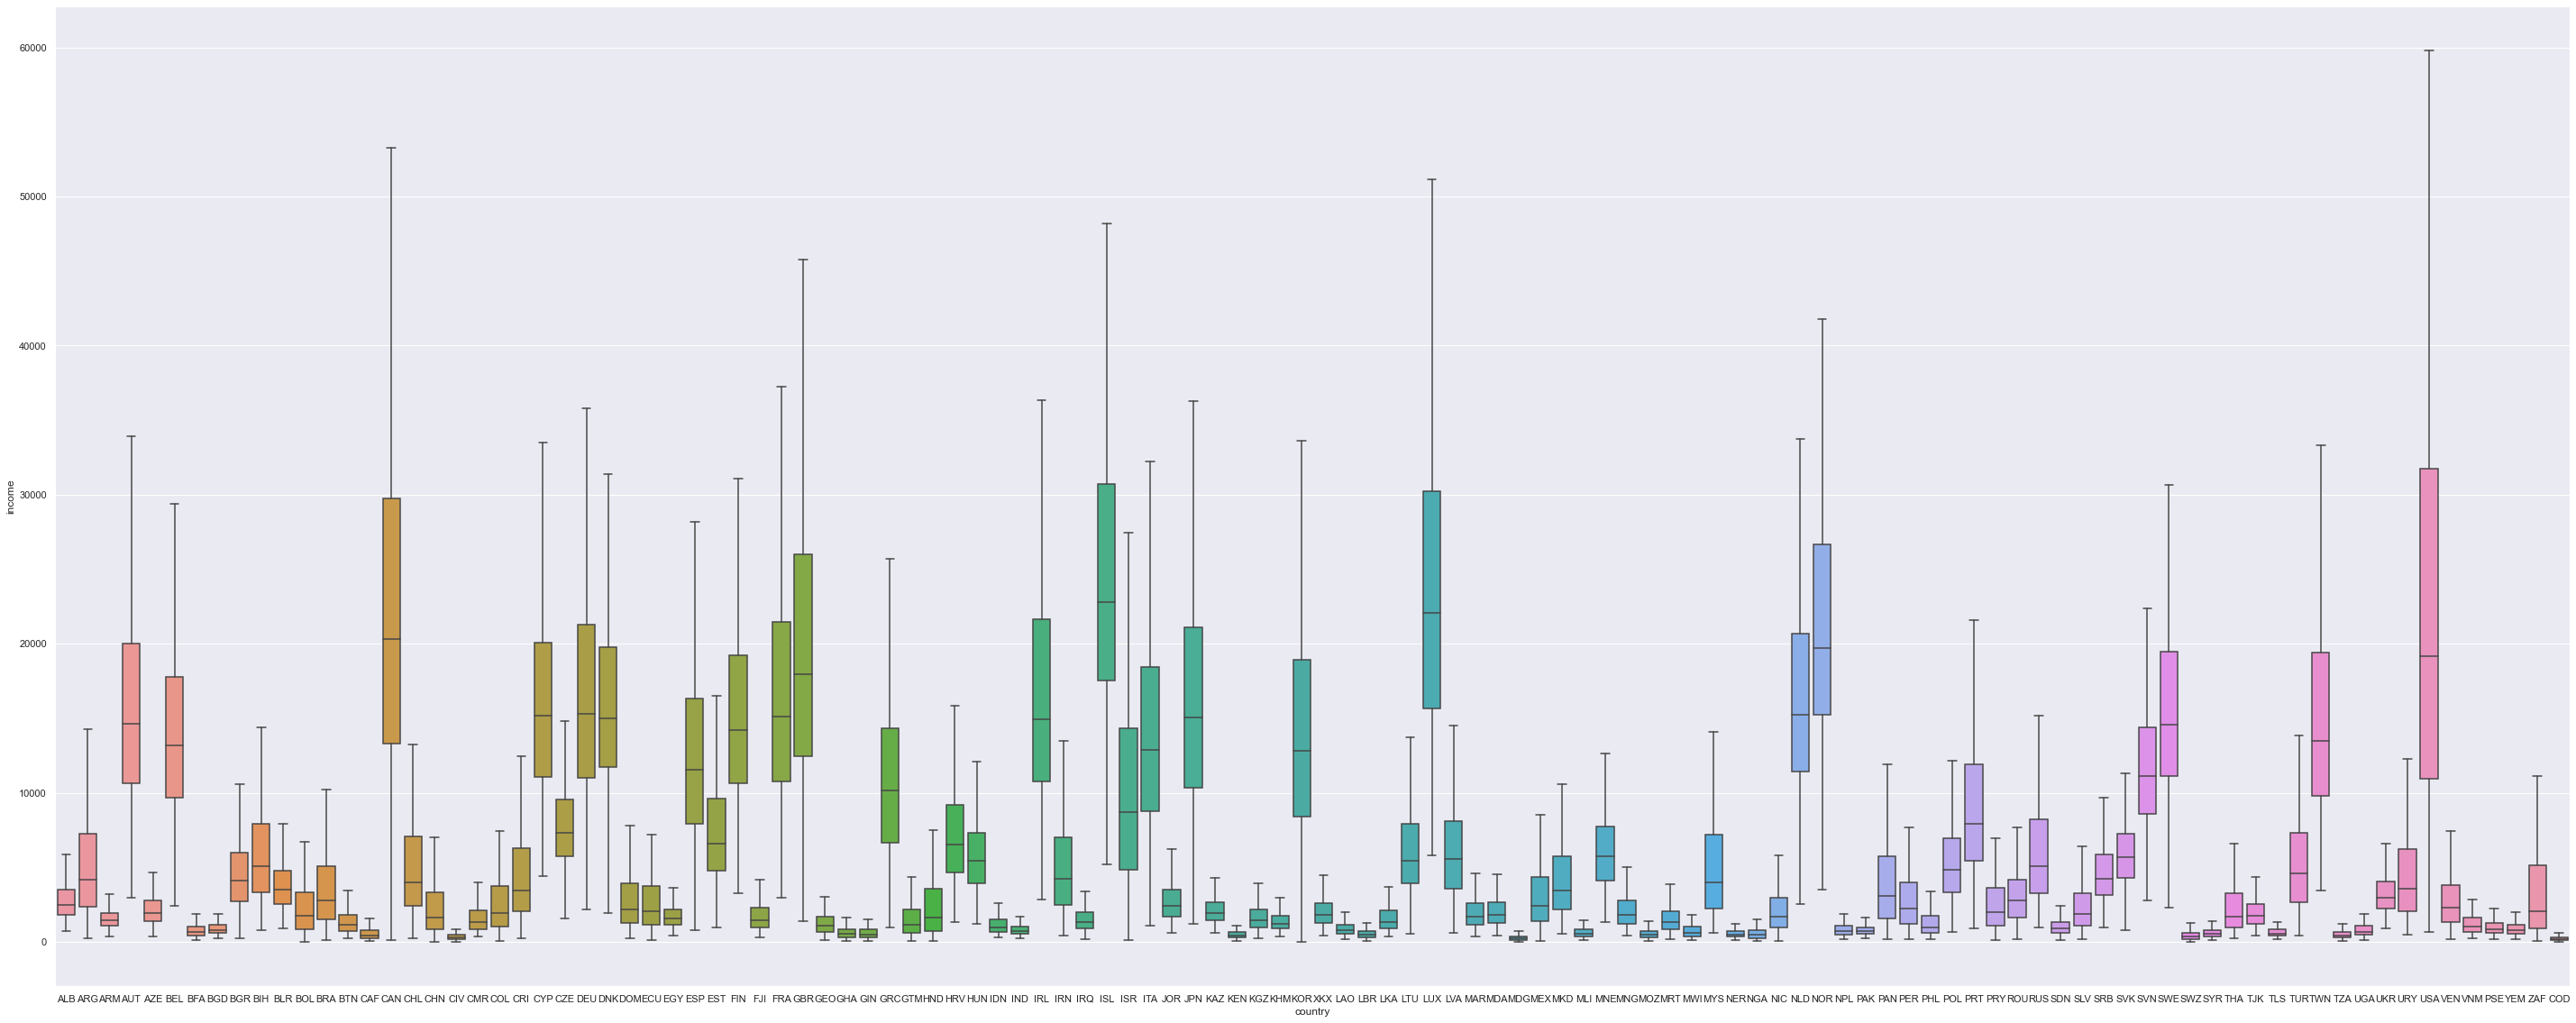

In [119]:
R = df_500_datap7_Gini_elasticity_boucle_moyen["income"]
V = df_500_datap7_Gini_elasticity_boucle_moyen["country"]
sns.set(rc={'figure.figsize':(50,20)})
ax = sns.boxplot(x="country", y ="income", data=df_500_datap7_Gini_elasticity_boucle_moyen, showfliers = False)

On note ici une grand disparité dans nos données. La variation de revenus est grande en fonction des pays. On va utiliser la méthode des moindres carrés ordinaires pour voir à quel point la variable "pays" explique la variance du revenu des individus.

In [120]:
mlr = smf.ols("income~country", data=df_500_datap7_Gini_elasticity_boucle_moyen).fit()
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 4.971e+04
Date:                Sun, 29 Jan 2023   Prob (F-statistic):               0.00
Time:                        01:21:11   Log-Likelihood:            -5.9310e+07
No. Observations:             5800000   AIC:                         1.186e+08
Df Residuals:                 5799884   BIC:                         1.186e+08
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2994.8299     29.875    100.

Le pays explique quasi 50% du revenu du pays. Les autres facteurs expliquent quand à eux la moitié de la variance du revenu.

In [121]:
sm.stats.anova_lm(mlr)

,df,sum_sq,mean_sq,F,PR(>F)
country,115.0,2.551188e+14,2.218424e+12,49710.75889,0.0
Residual,5799884.0,2.588293e+14,4.462664e+07,NaN,NaN


Le p value est inférieur à 0.05, donc le pays a bien une influence sur le revenu.

### Même méthode mais avec des valeurs en log

In [122]:
#ici c'est en log
mlr_log = smf.ols("income~country", data=anova2).fit()
print(mlr_log.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                 1.358e+05
Date:                Sun, 29 Jan 2023   Prob (F-statistic):               0.00
Time:                        01:22:53   Log-Likelihood:            -6.3135e+06
No. Observations:             5800000   AIC:                         1.263e+07
Df Residuals:                 5799884   BIC:                         1.263e+07
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.8517      0.003   2443.

In [123]:
sm.stats.anova_lm(mlr_log)

,df,sum_sq,mean_sq,F,PR(>F)
country,115.0,8.067209e+06,70149.642830,135832.373967,0.0
Residual,5799884.0,2.995308e+06,0.516443,NaN,NaN


Le p value est inférieur à 0.05, donc le pays a bien une influence sur le revenu.

### Vérifier si les résidus de l'ANOVA ont bien une distribution gaussienne.

C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


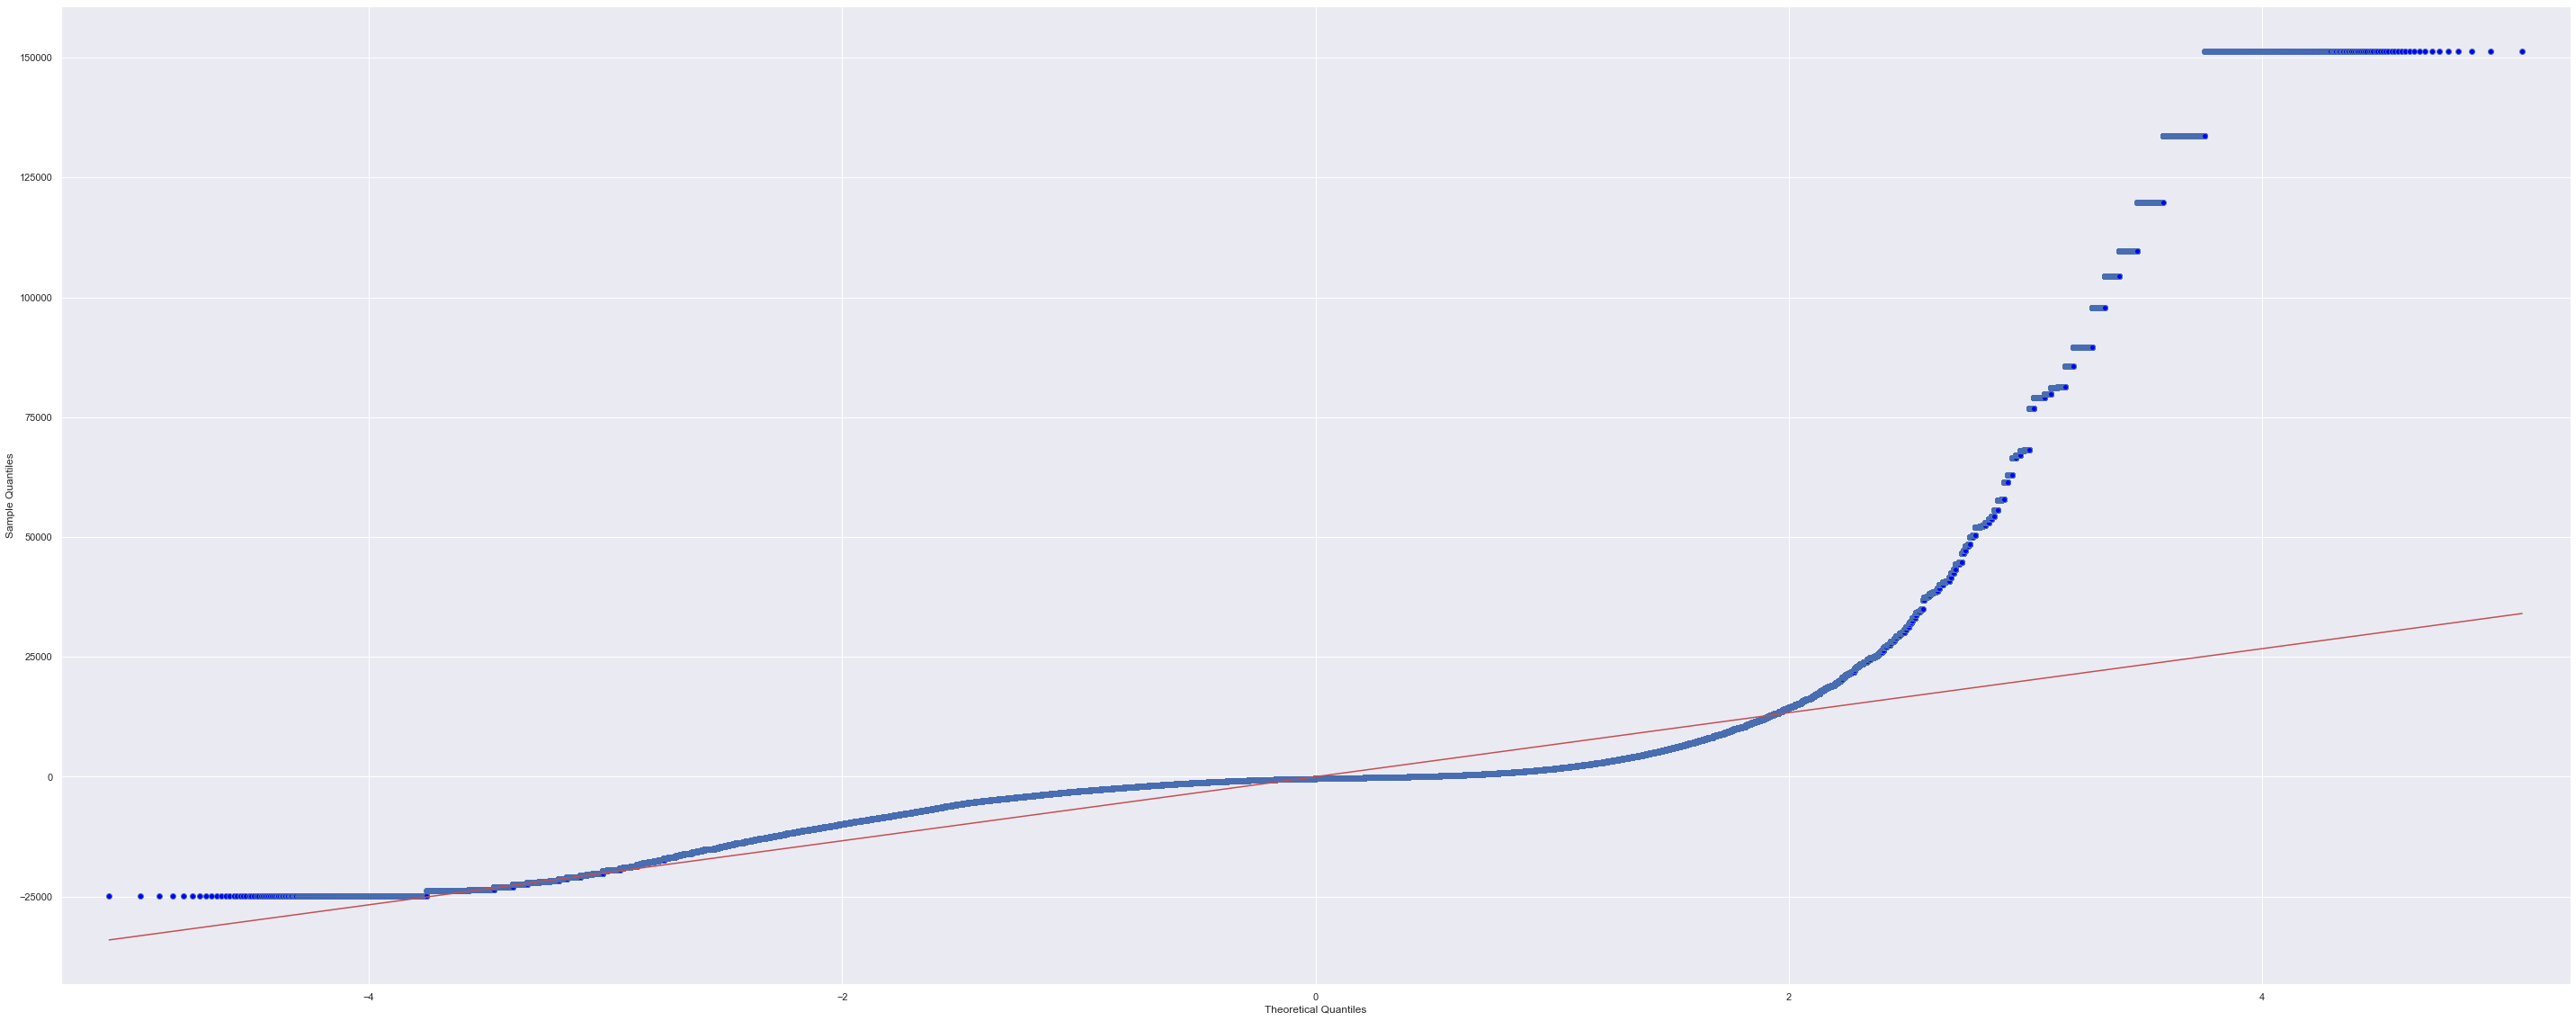

In [124]:
#Droite de Henry
res = mlr.resid
fig = sm.qqplot(res, line='s')
plt.show()

LA distribution ici ne suit pas la droite, donc la distributiuon n'est pas normale

## Appliquez une régression linéaire sur vos données, en incluant comme variables explicatives uniquement le revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu. Quel est le pourcentage de variance expliquée par votre modèle ?

Une regression linéaire c'est quoi ? C'est un algorithme qui fait aprtie de la classe des régressions, donc qui prédit un chiffre. Elle peut être univariée, donc une seule variable explicative (une seule colonne dans notre dataframe) pour expliquer une autre colonne qui est la target. Ex: expiquer le prix d'un appart en se basant sur X la surface.

Si elle était multivariée ce serait si on prenait plusieurs colonnes, donc plusieurs vairables. Dans le cas d'un appartement cela voudrait dire que l'on prend en compte par exemple le lieu, l'exposition...

La premiere chose que l'on a fait est de faire une régression sur les données sans trop de modification. Ensuite on a vérifié un score qui est l'écart par rapport à la réalité. PLus modèle arrive à reproduire des valeurs qui sont proches des valeurs réelles, plus il est performant.

L'autre étape est d'utiliser une ANOVA, qui est l'analyse de la variance. On voit s'il y a une corrélation entre une variable quantitaive et qualitative. Parmi les statistiques données une intéressante est la P-value, qui ets une valeur de vraissemblance. S'il est inférieure à 5% alors elle confirme l'hypothèse standard. Autrement elle contredit l'hypothèse standard.

In [125]:
y = df_500_datap7_Gini_elasticity_boucle_moyen["income"]
X = df_500_datap7_Gini_elasticity_boucle_moyen[["income_moyen","indice"]]
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Instanciation du modèle
linreg = LinearRegression()
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [127]:
# Entraînement du modèle sur le jeu d'entraînement
linreg.fit(X_train, y_train)
# Prédiction de la variable cible pour le jeu de données test. Ces prédictions sont stockées dans y_pred
y_pred_train = linreg.predict(X_train)
y_pred_test = linreg.predict(X_test)

In [128]:
import sklearn.metrics
from sklearn.metrics import mean_squared_error
mse_train=mean_squared_error(y_train,y_pred_train)
mse_test=mean_squared_error(y_test,y_pred_test)
print("MSE_train= ",mse_train)
print("MSE_test= ",mse_test)

MSE_train=  44591331.243631415
MSE_test=  44763487.536893375


In [129]:
# definition des fonctions pour les différents modèles
import sklearn.metrics as sklm
import math
# calcul des R² et R² ajustés
def print_metrics(y_true, y_predicted):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    #r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    #print('Adjusted R^2           = ' + str(r2_adj))
    
# affichage de l'histogramme des résidus
def hist_resids(y_test, y_score, modele):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals ' + modele)
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
# affichage du Q-Q plot
def resid_qq(y_test, y_score, modele):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    st.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values ' + modele)
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')

# affichage du tracé des résidus (en log)
def resid_plot(y_test, y_score, modele):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values ' + modele)
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')


In [130]:
print_metrics(y_test, y_pred_test)

Mean Square Error      = 44763487.536893375
Root Mean Square Error = 6690.552110020022
Mean Absolute Error    = 2979.661905308889
Median Absolute Error  = 1190.7379417878897
R^2                    = 0.49667351501201484


In [131]:
df_y_test = np.array(y_test)
df_y_pred = np.array(y_pred_test)

C:\Users\jb-14\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


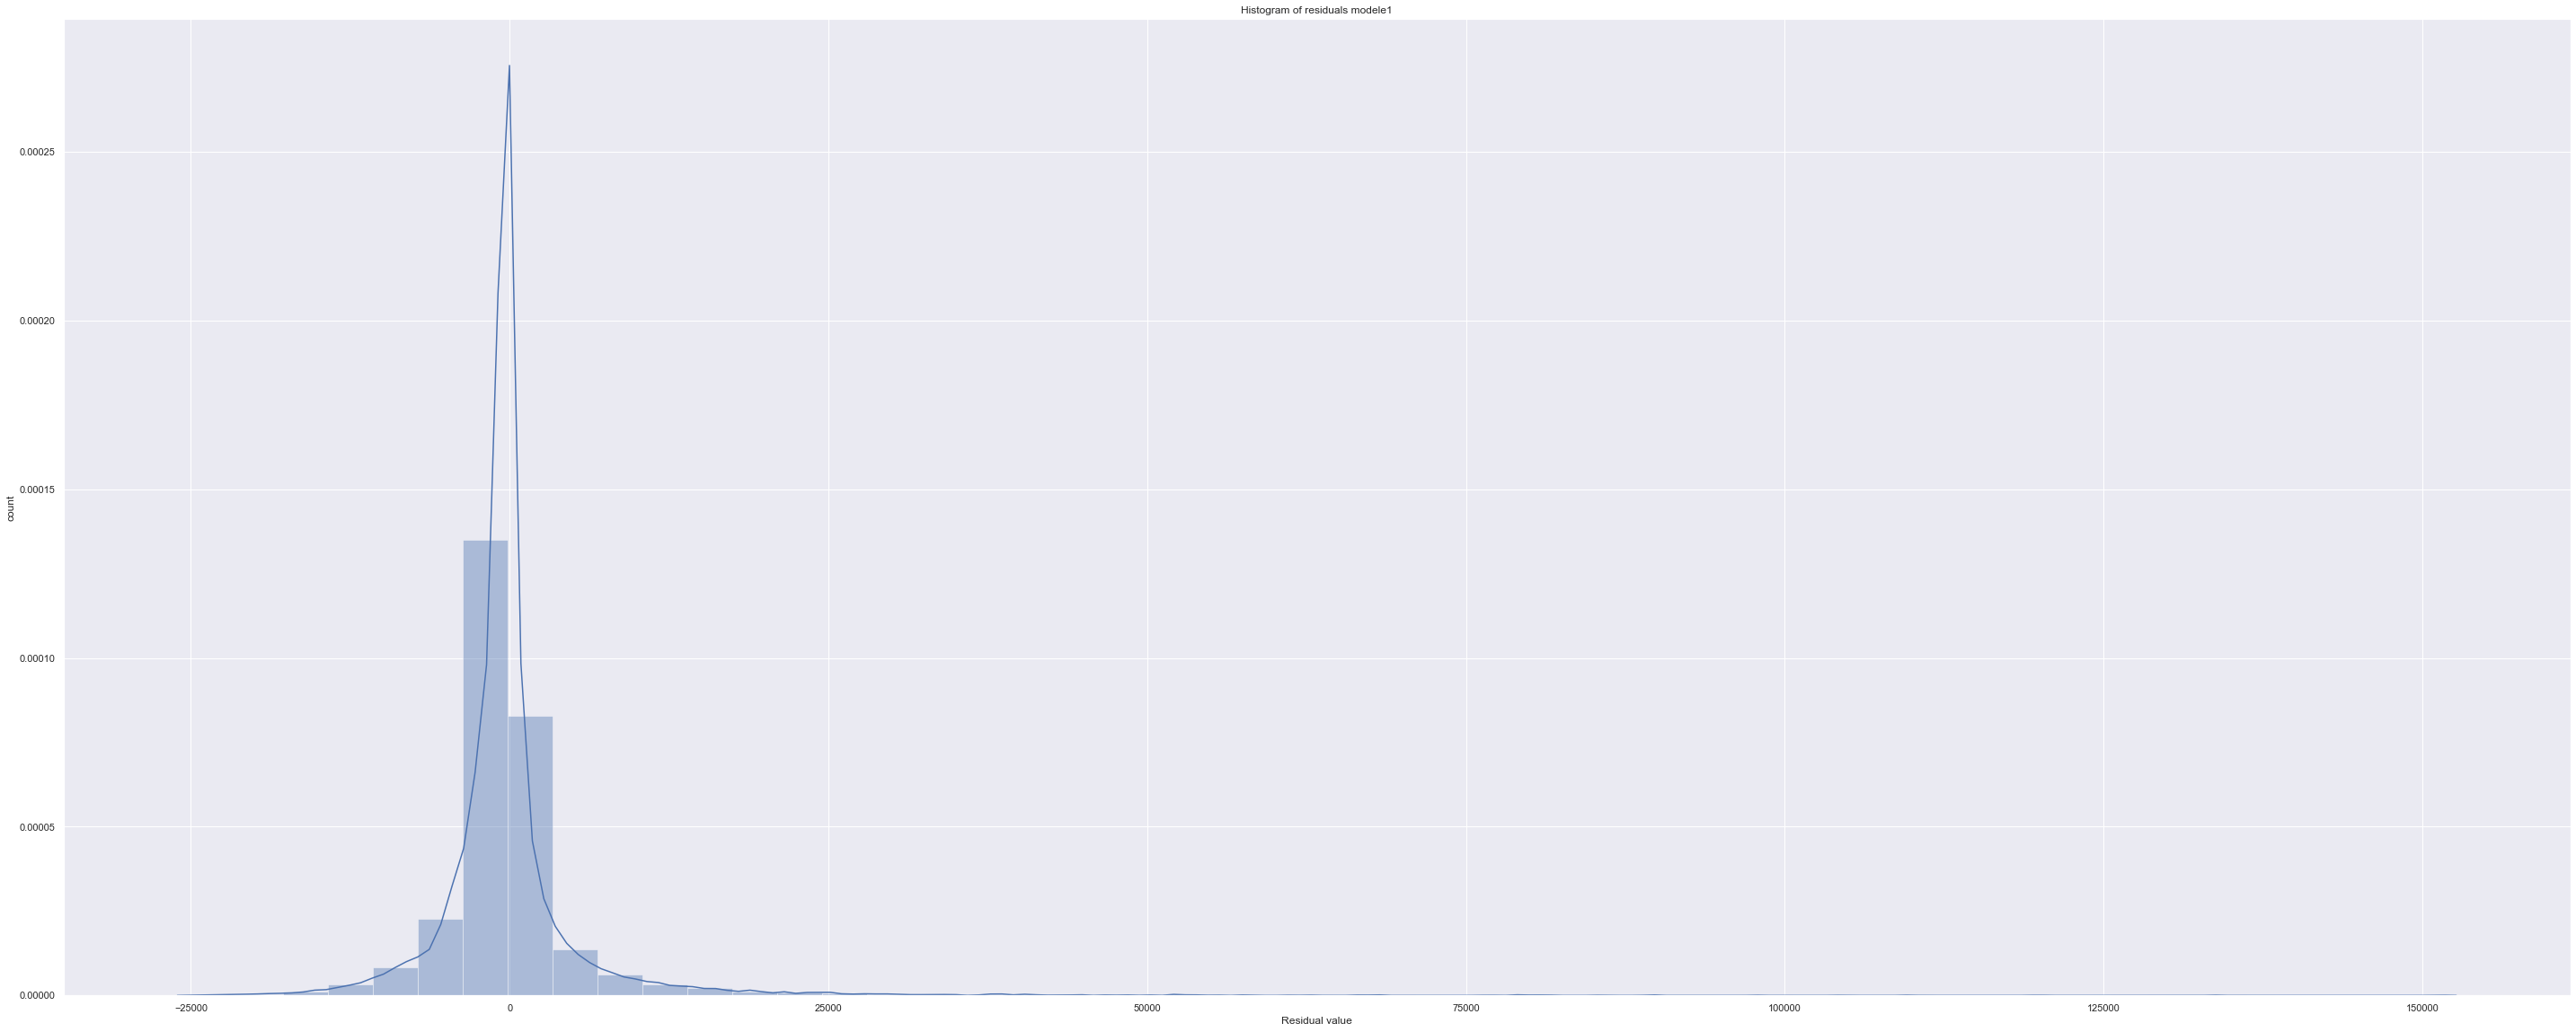

In [132]:
hist_resids(df_y_test, df_y_pred, "modele1")

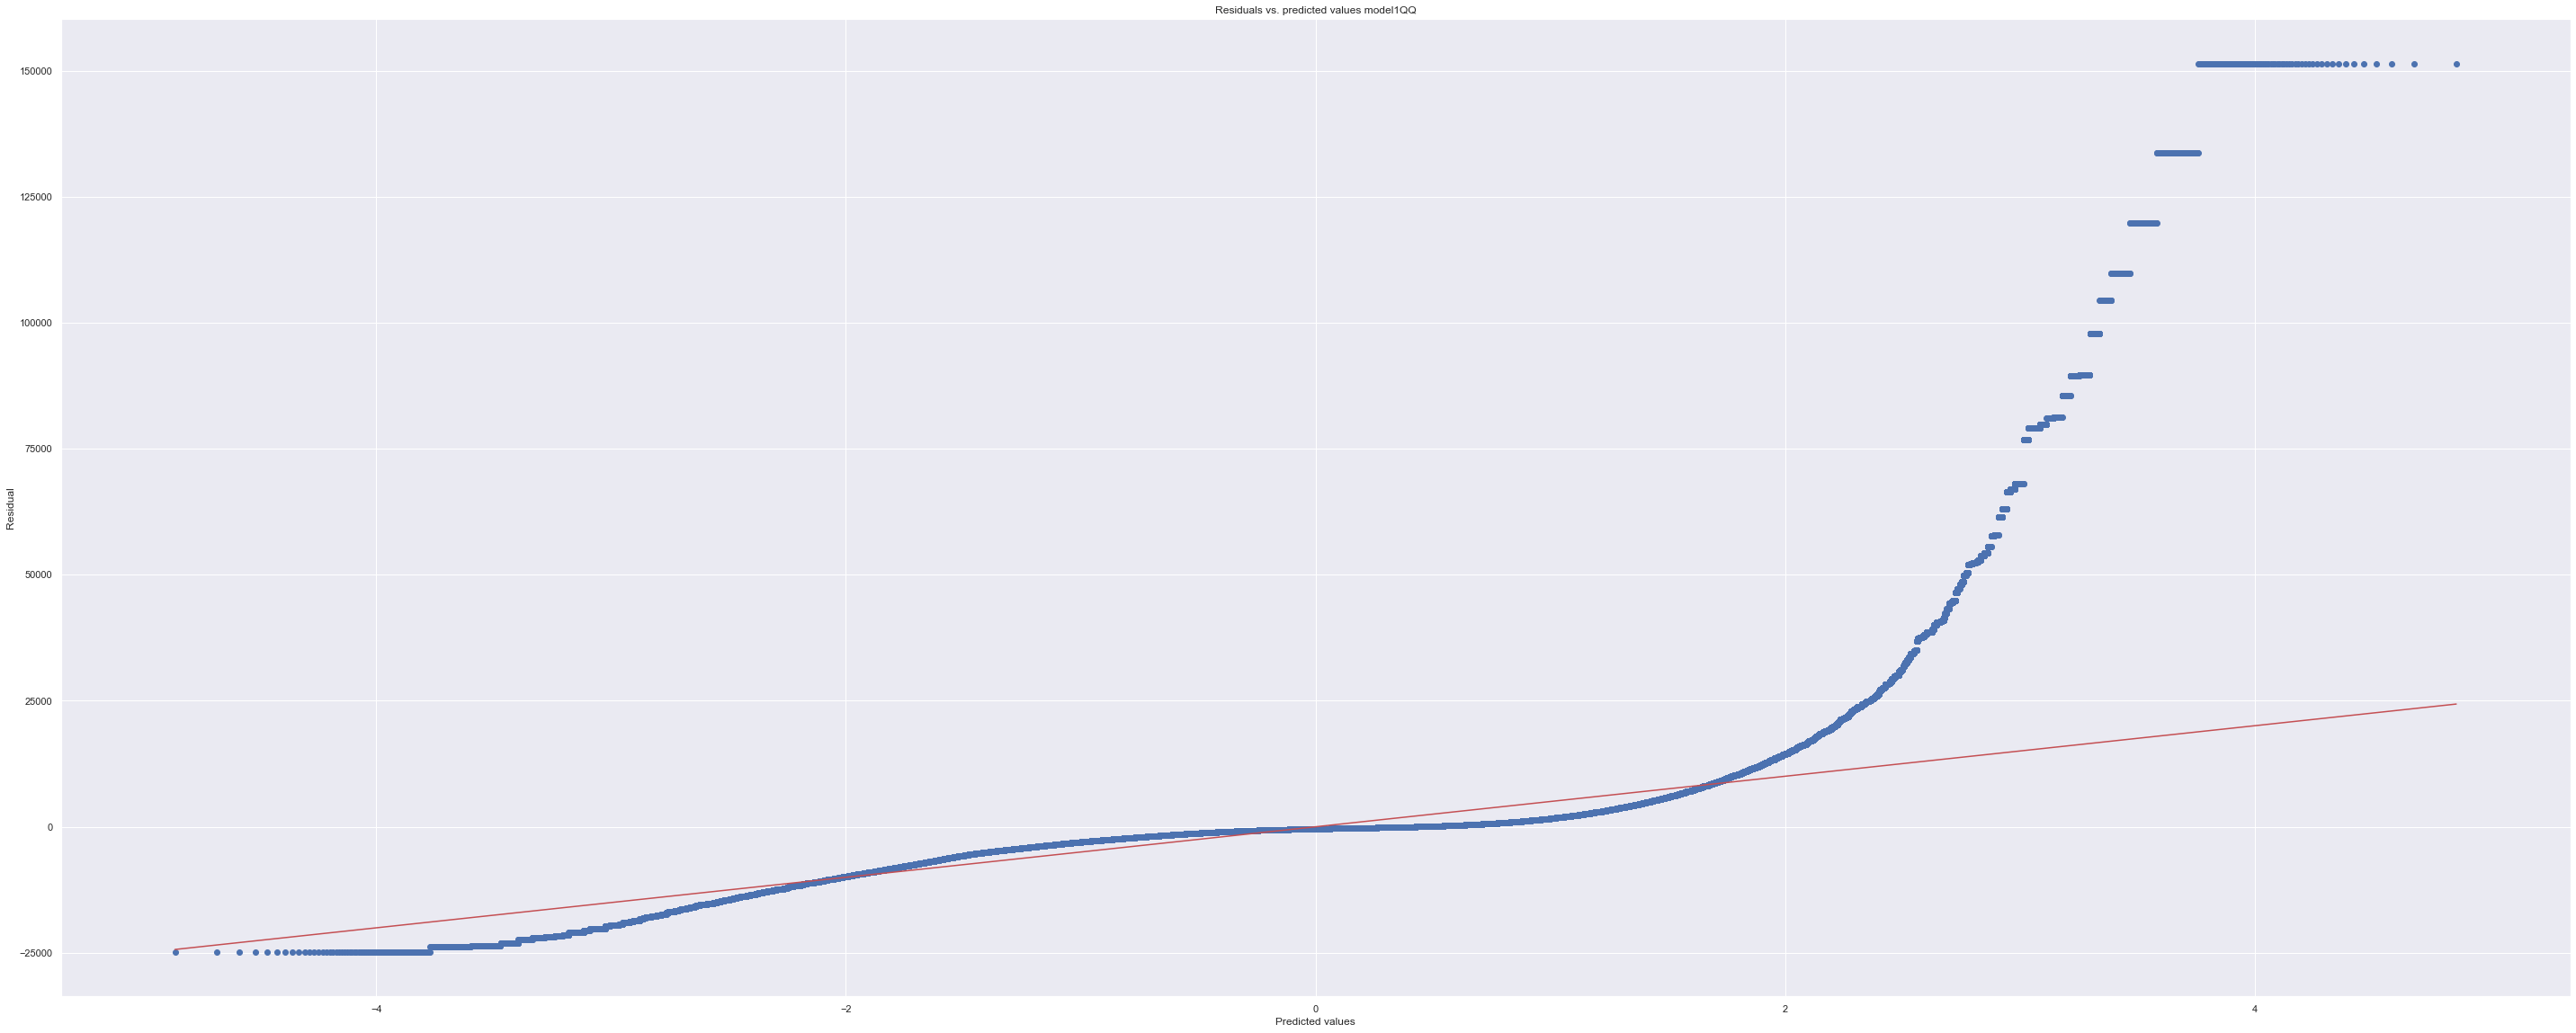

In [133]:
resid_qq(df_y_test, df_y_pred, "model1QQ")

C:\Users\jb-14\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


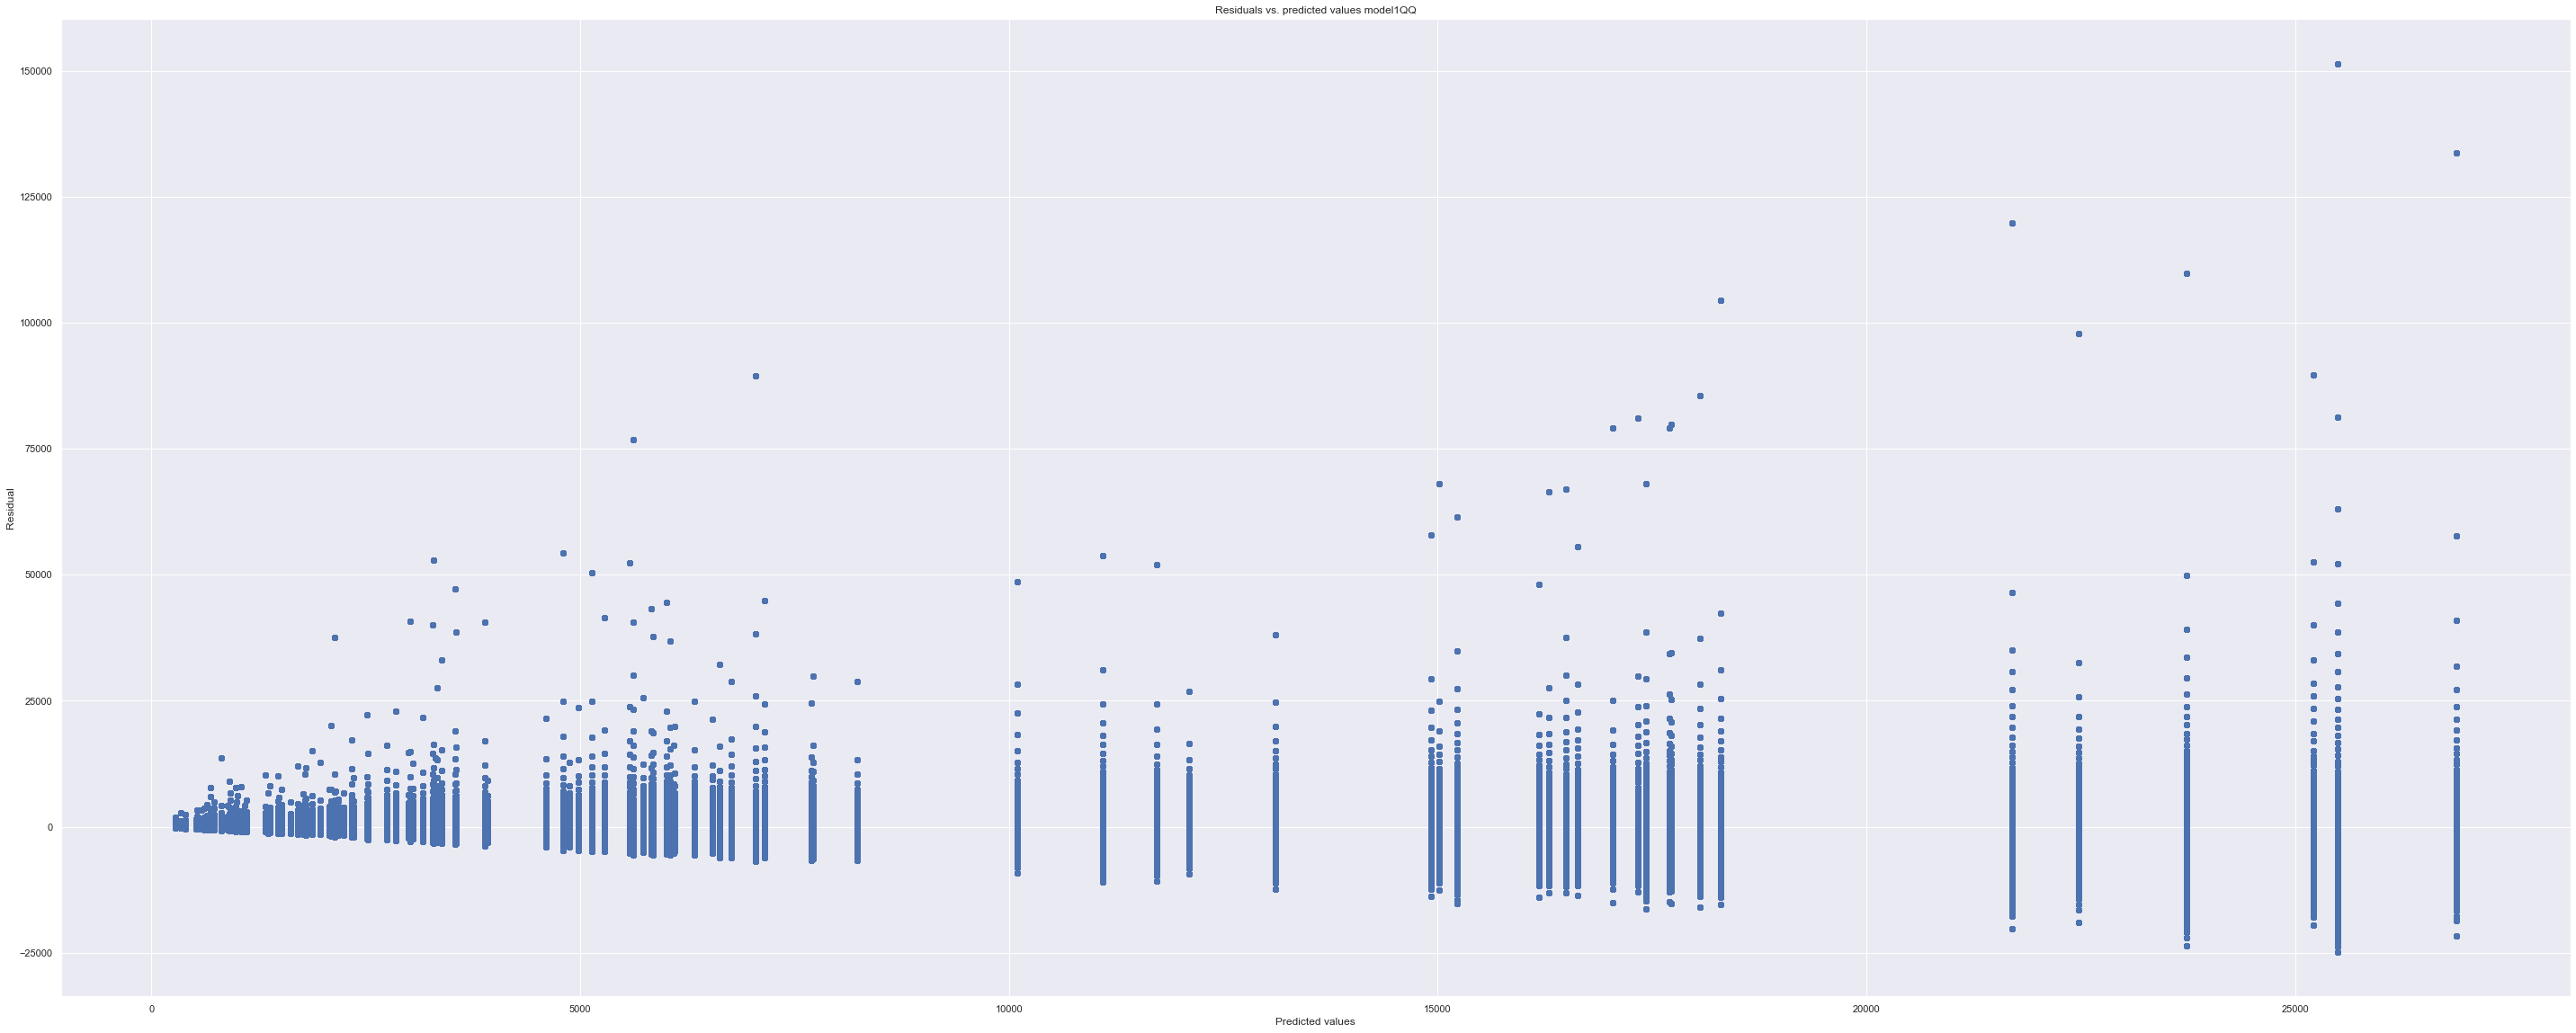

In [134]:
resid_plot(df_y_test, df_y_pred, "model1QQ")

In [135]:
df2 = df_500_datap7_Gini_elasticity_boucle_moyen.copy()
df2["income"] = np.log(df2["income"])
df2["income_moyen"] = np.log(df2["income_moyen"])

In [136]:
y = df2["income"]
X = df2[["income_moyen","indice"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Instanciation du modèle
linreg = LinearRegression()
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [137]:
# Entraînement du modèle sur le jeu d'entraînement
linreg.fit(X_train, y_train)
# Prédiction de la variable cible pour le jeu de données test. Ces prédictions sont stockées dans y_pred
y_pred_train = linreg.predict(X_train)
y_pred_test = linreg.predict(X_test)
mse_train=mean_squared_error(y_train,y_pred_train)
mse_test=mean_squared_error(y_test,y_pred_test)
print("MSE_train= ",mse_train)
print("MSE_test= ",mse_test)

MSE_train=  0.5185929963476091
MSE_test=  0.5192189713238211


In [138]:
print_metrics(y_test, y_pred_test)

Mean Square Error      = 0.5192189713238211
Root Mean Square Error = 0.7205685056424692
Mean Absolute Error    = 0.5368529145111248
Median Absolute Error  = 0.41456474669783194
R^2                    = 0.7279311290877073


C:\Users\jb-14\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


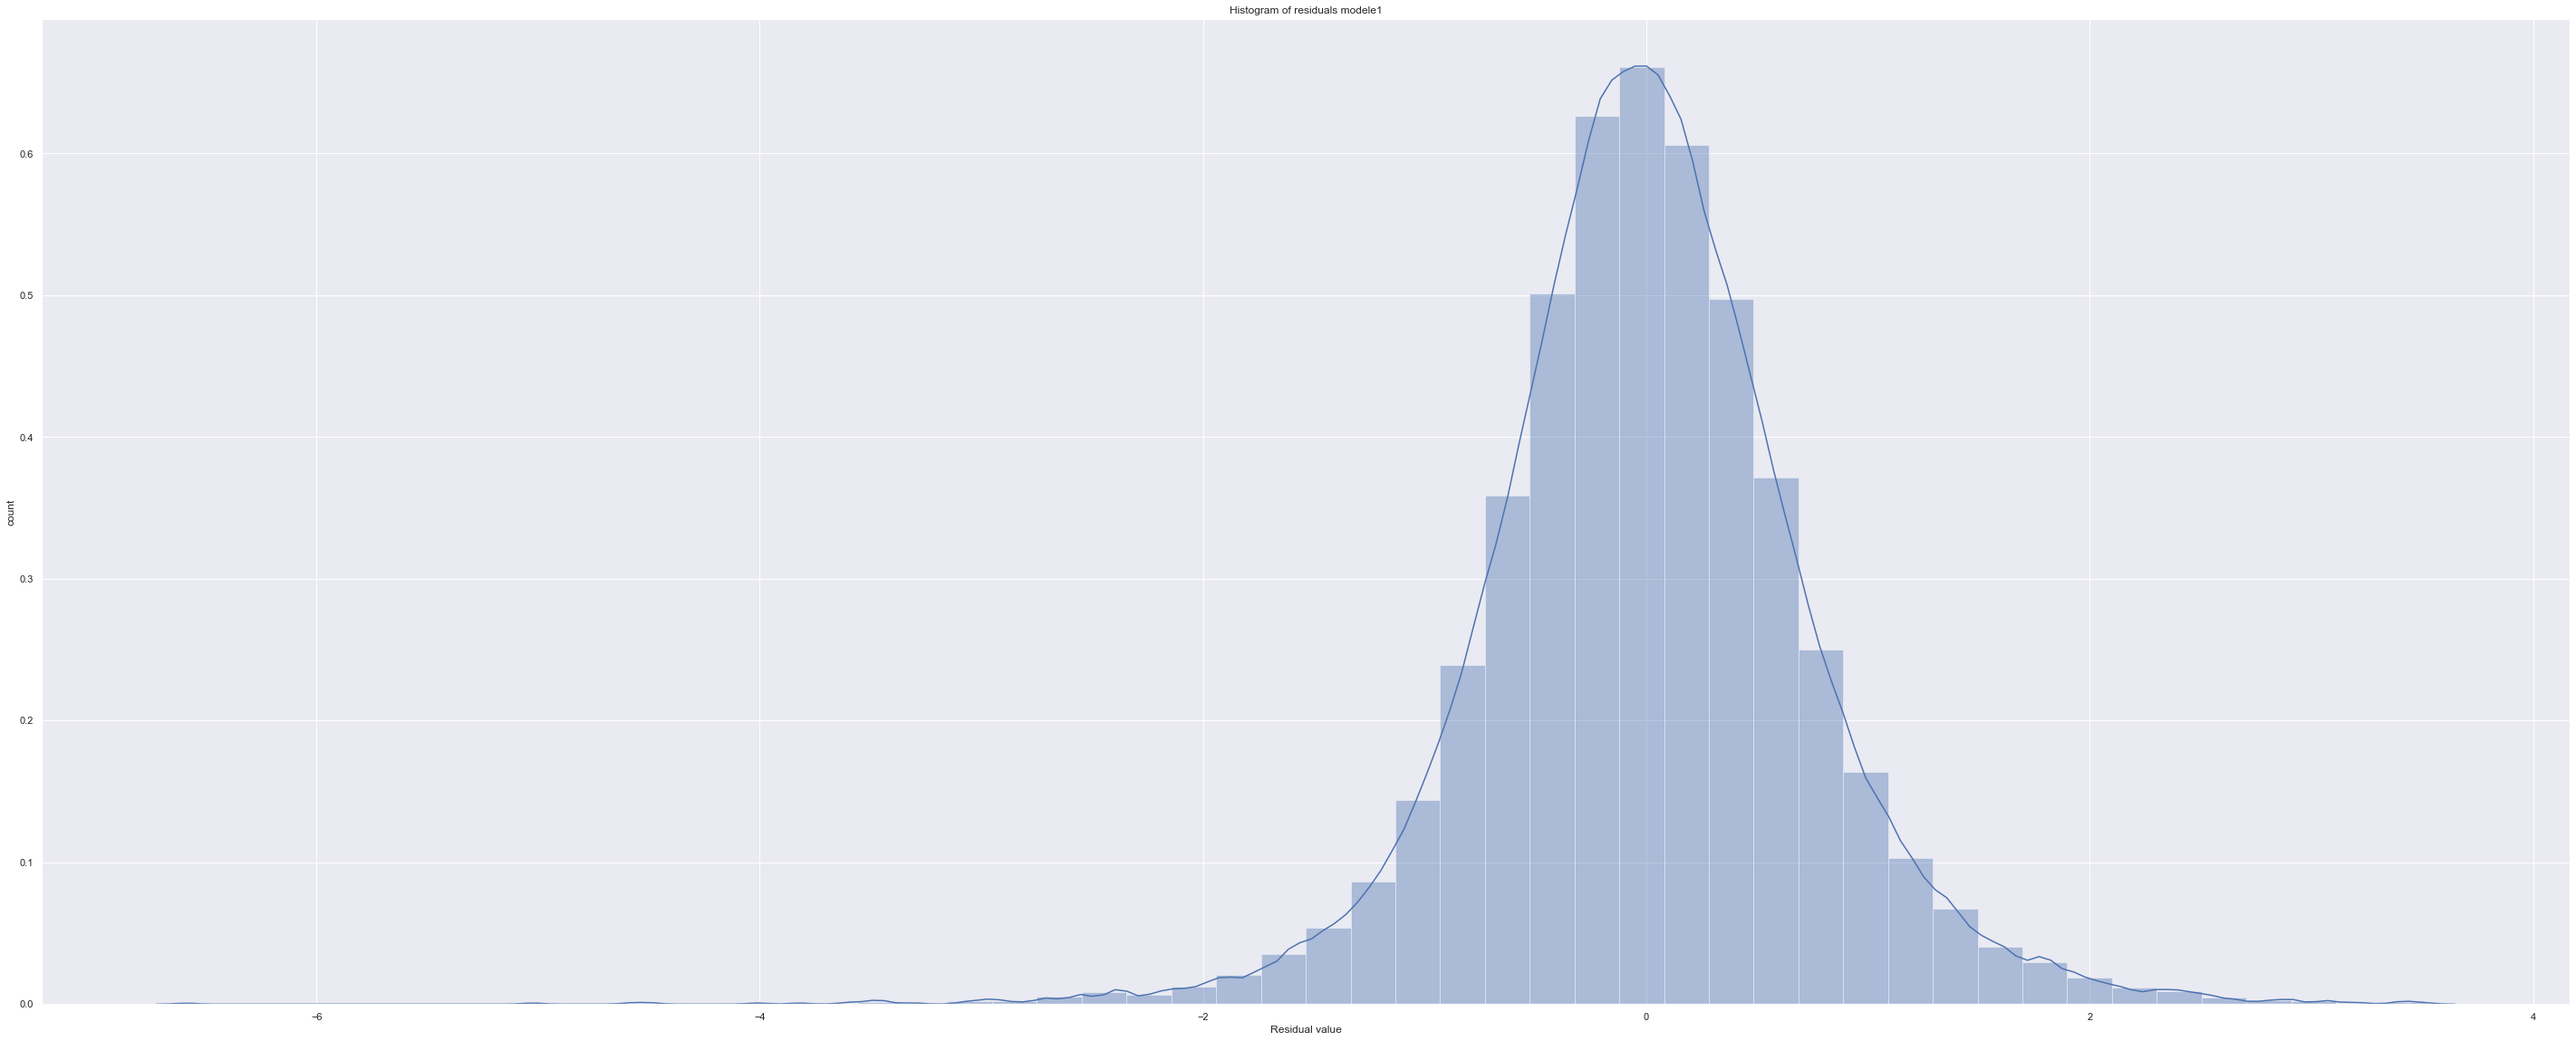

In [139]:
df_y_test = np.array(y_test)
df_y_pred = np.array(y_pred_test)
hist_resids(df_y_test, df_y_pred, "modele1")

C:\Users\jb-14\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


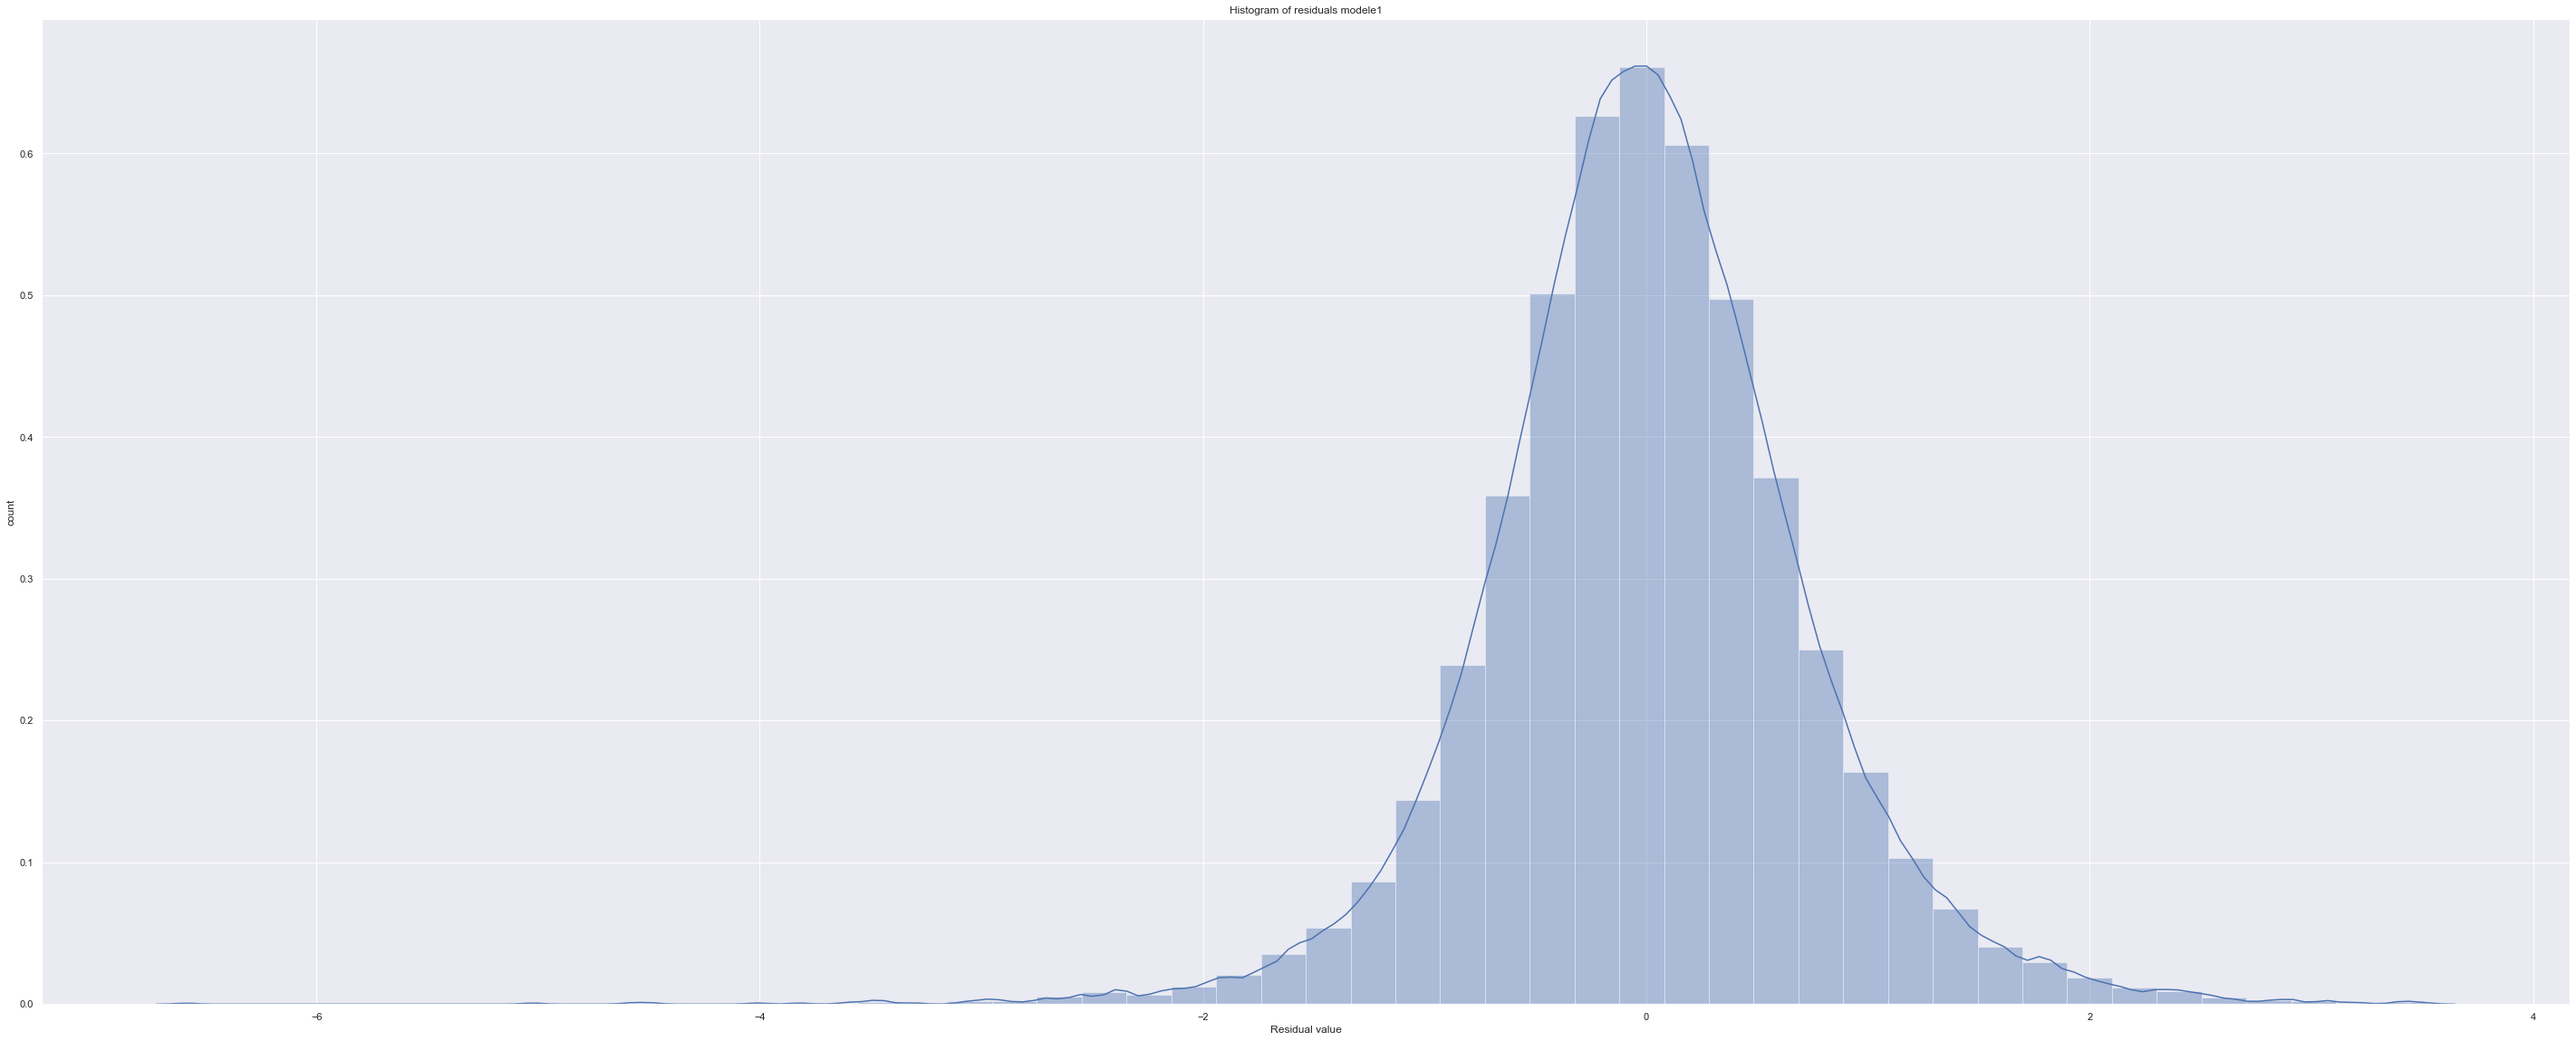

In [140]:
df_y_test = np.array(y_test)
df_y_pred = np.array(y_pred_test)
hist_resids(df_y_test, df_y_pred, "modele1")

C:\Users\jb-14\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


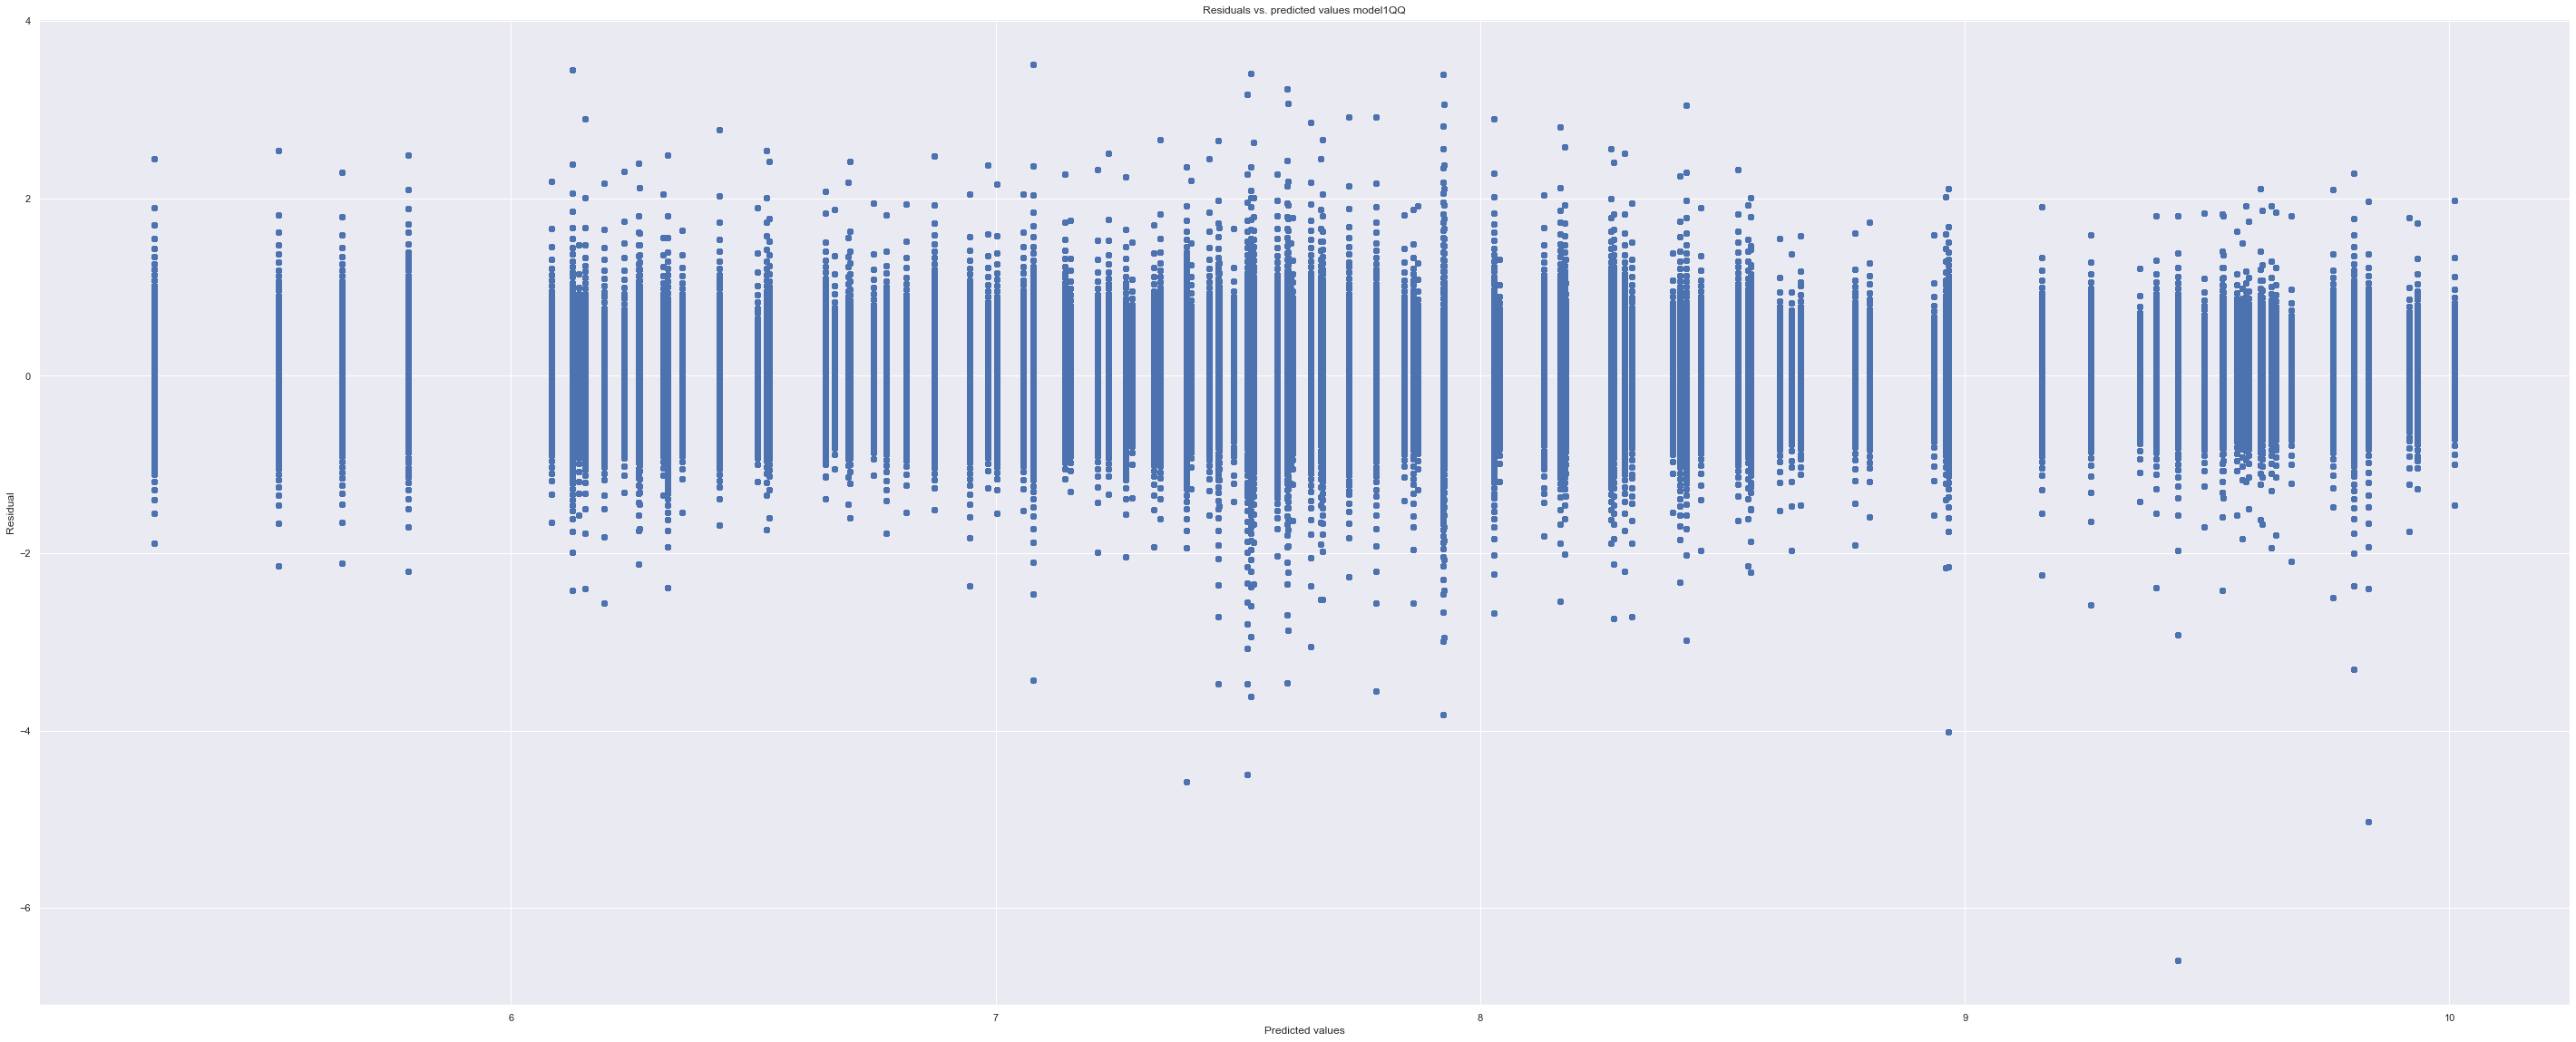

In [141]:
resid_plot(df_y_test, df_y_pred, "model1QQ")

In [142]:
y = df_500_datap7_Gini_elasticity_boucle_moyen["income"]
X = df_500_datap7_Gini_elasticity_boucle_moyen[["income_moyen","indice", "c_i_child"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Instanciation du modèle
linreg = LinearRegression()
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [143]:
# Entraînement du modèle sur le jeu d'entraînement
linreg.fit(X_train, y_train)
# Prédiction de la variable cible pour le jeu de données test. Ces prédictions sont stockées dans y_pred
y_pred_train = linreg.predict(X_train)
y_pred_test = linreg.predict(X_test)
mse_train=mean_squared_error(y_train,y_pred_train)
mse_test=mean_squared_error(y_test,y_pred_test)
print("MSE_train= ",mse_train)
print("MSE_test= ",mse_test)

MSE_train=  31597116.019391473
MSE_test=  31257766.59286646


In [144]:
print_metrics(y_test, y_pred_test)

Mean Square Error      = 31257766.59286646
Root Mean Square Error = 5590.864565777502
Mean Absolute Error    = 2850.745435979708
Median Absolute Error  = 2112.466187322101
R^2                    = 0.6444890748177059


C:\Users\jb-14\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


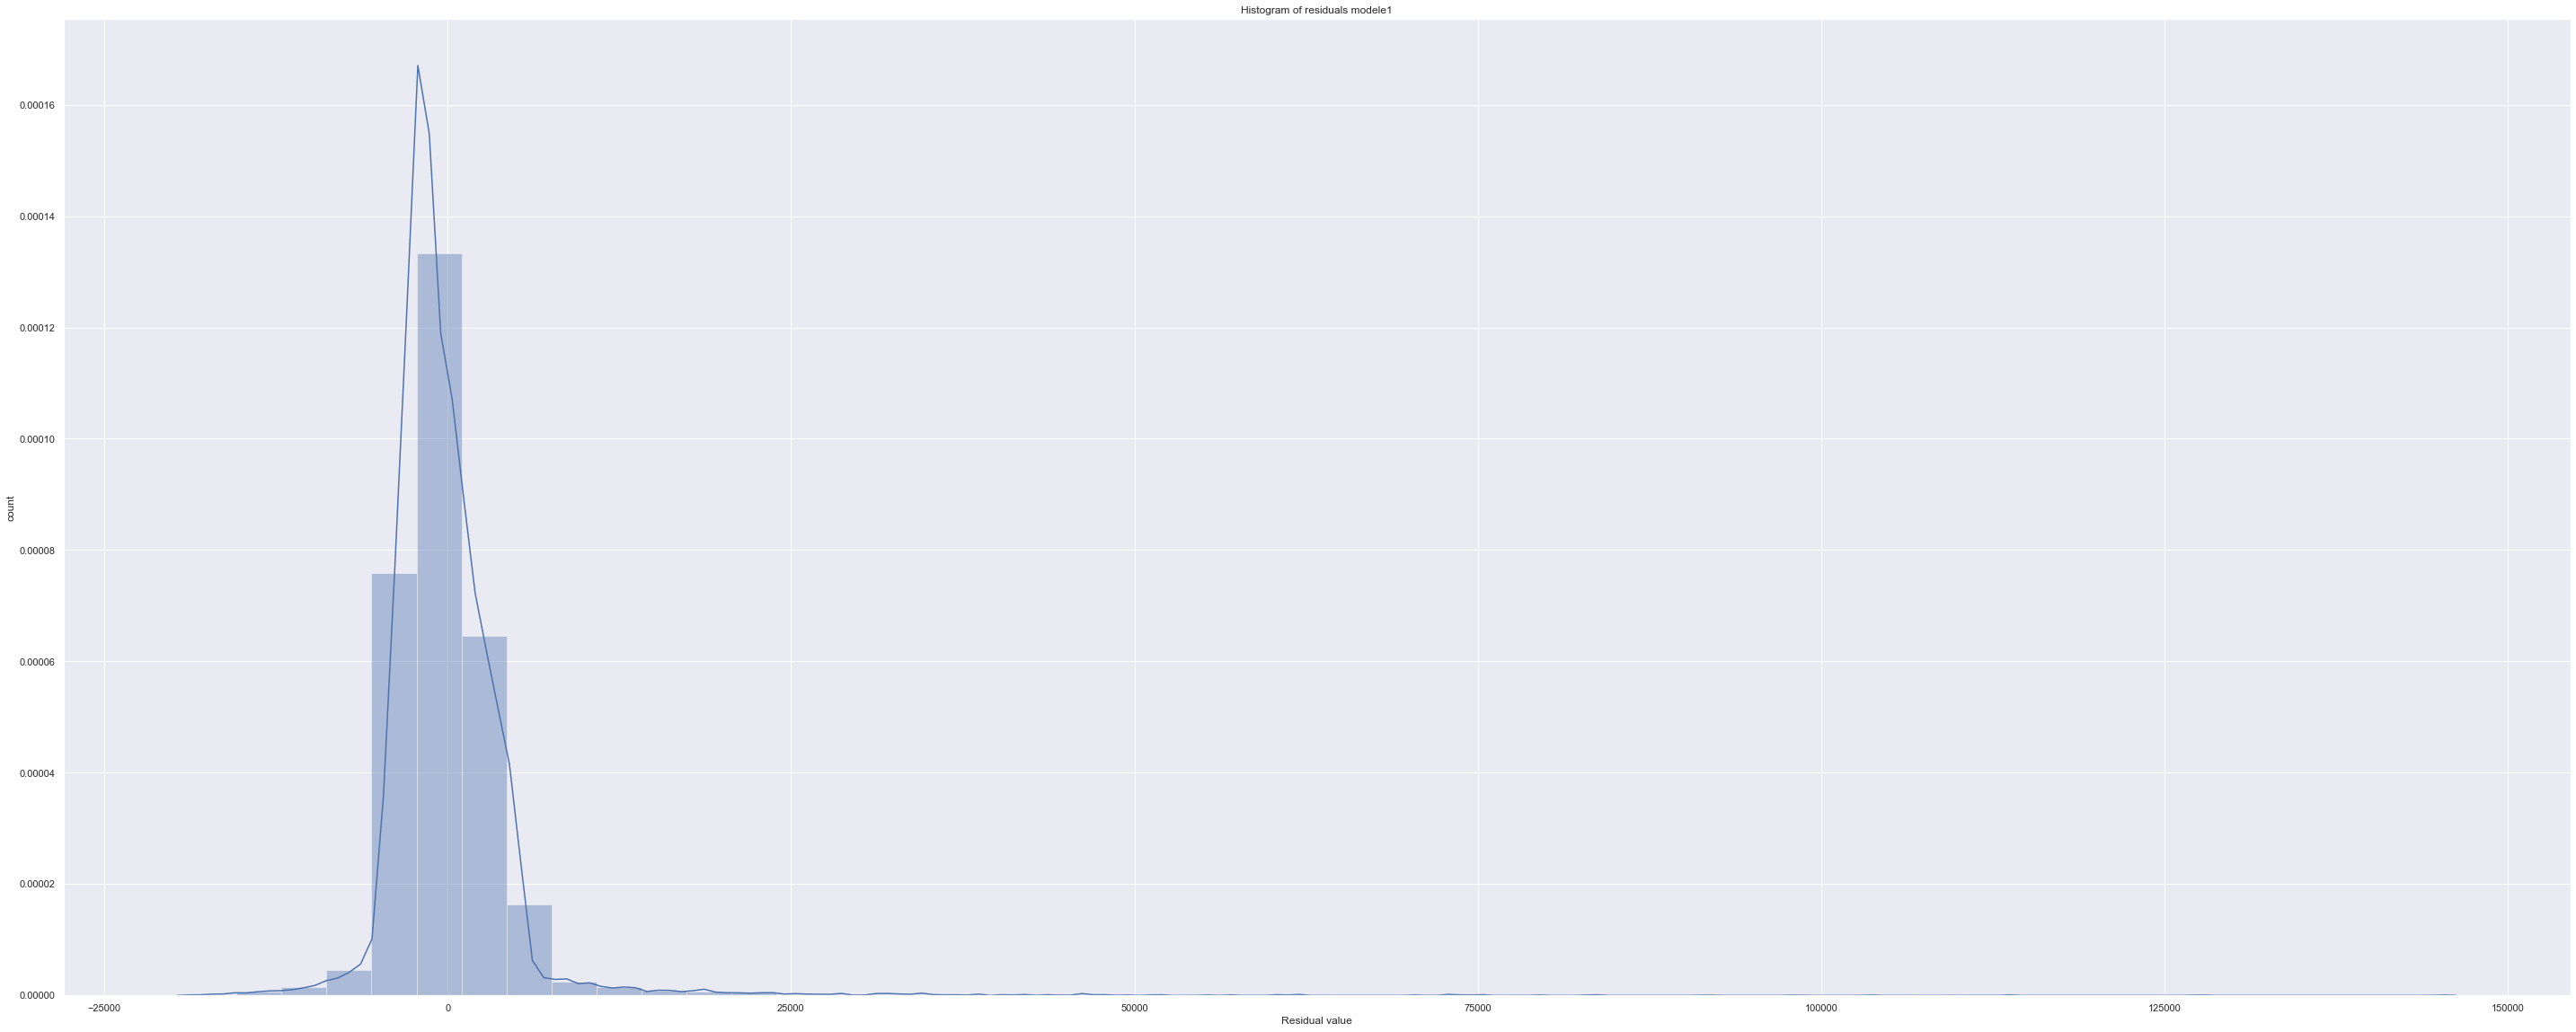

In [145]:
df_y_test = np.array(y_test)
df_y_pred = np.array(y_pred_test)
hist_resids(df_y_test, df_y_pred, "modele1")

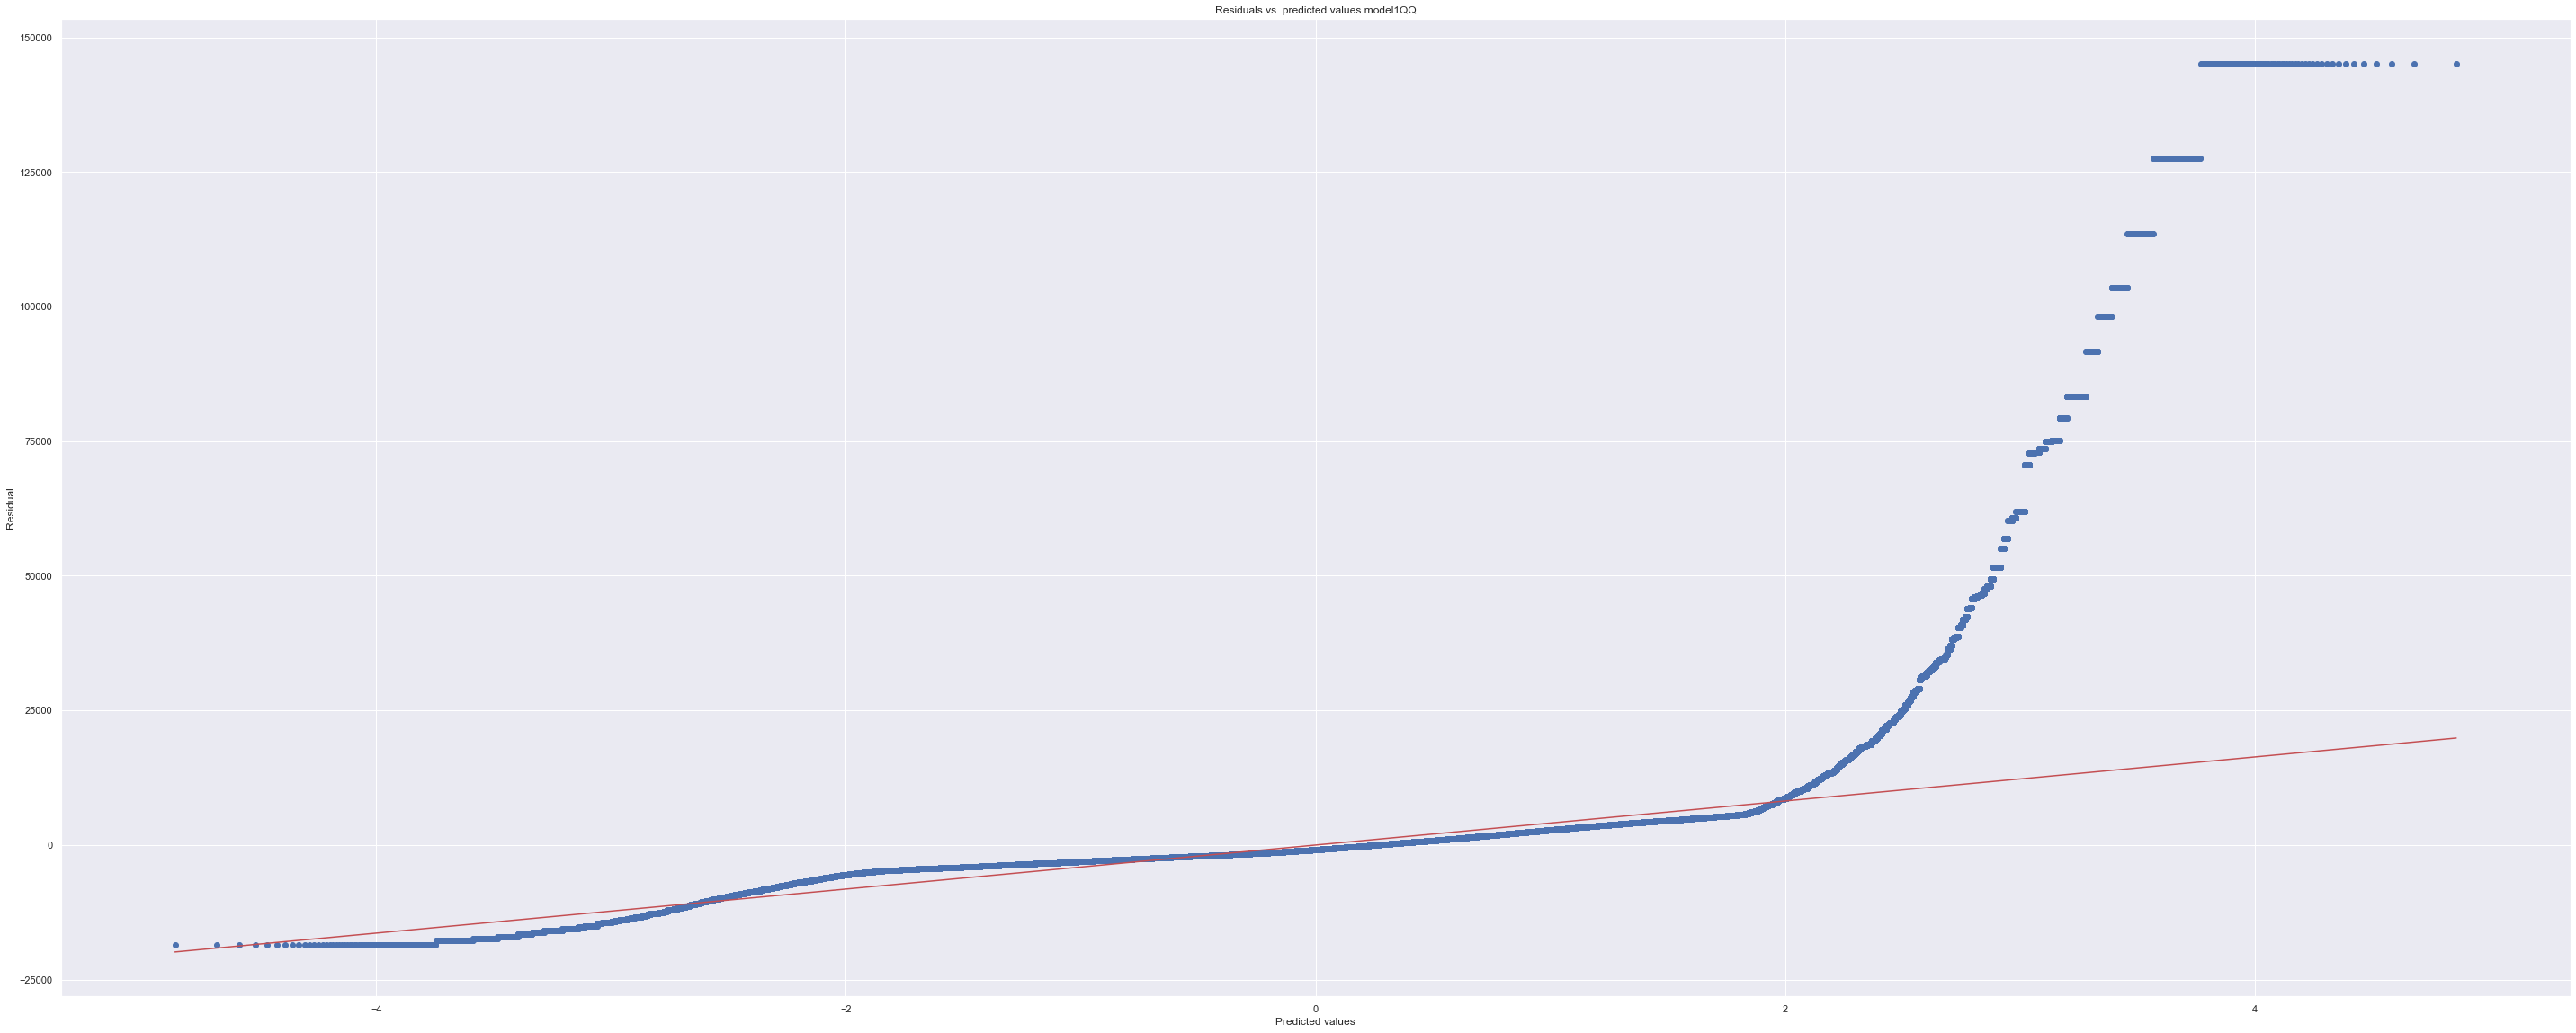

In [146]:
resid_qq(df_y_test, df_y_pred, "model1QQ")

C:\Users\jb-14\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


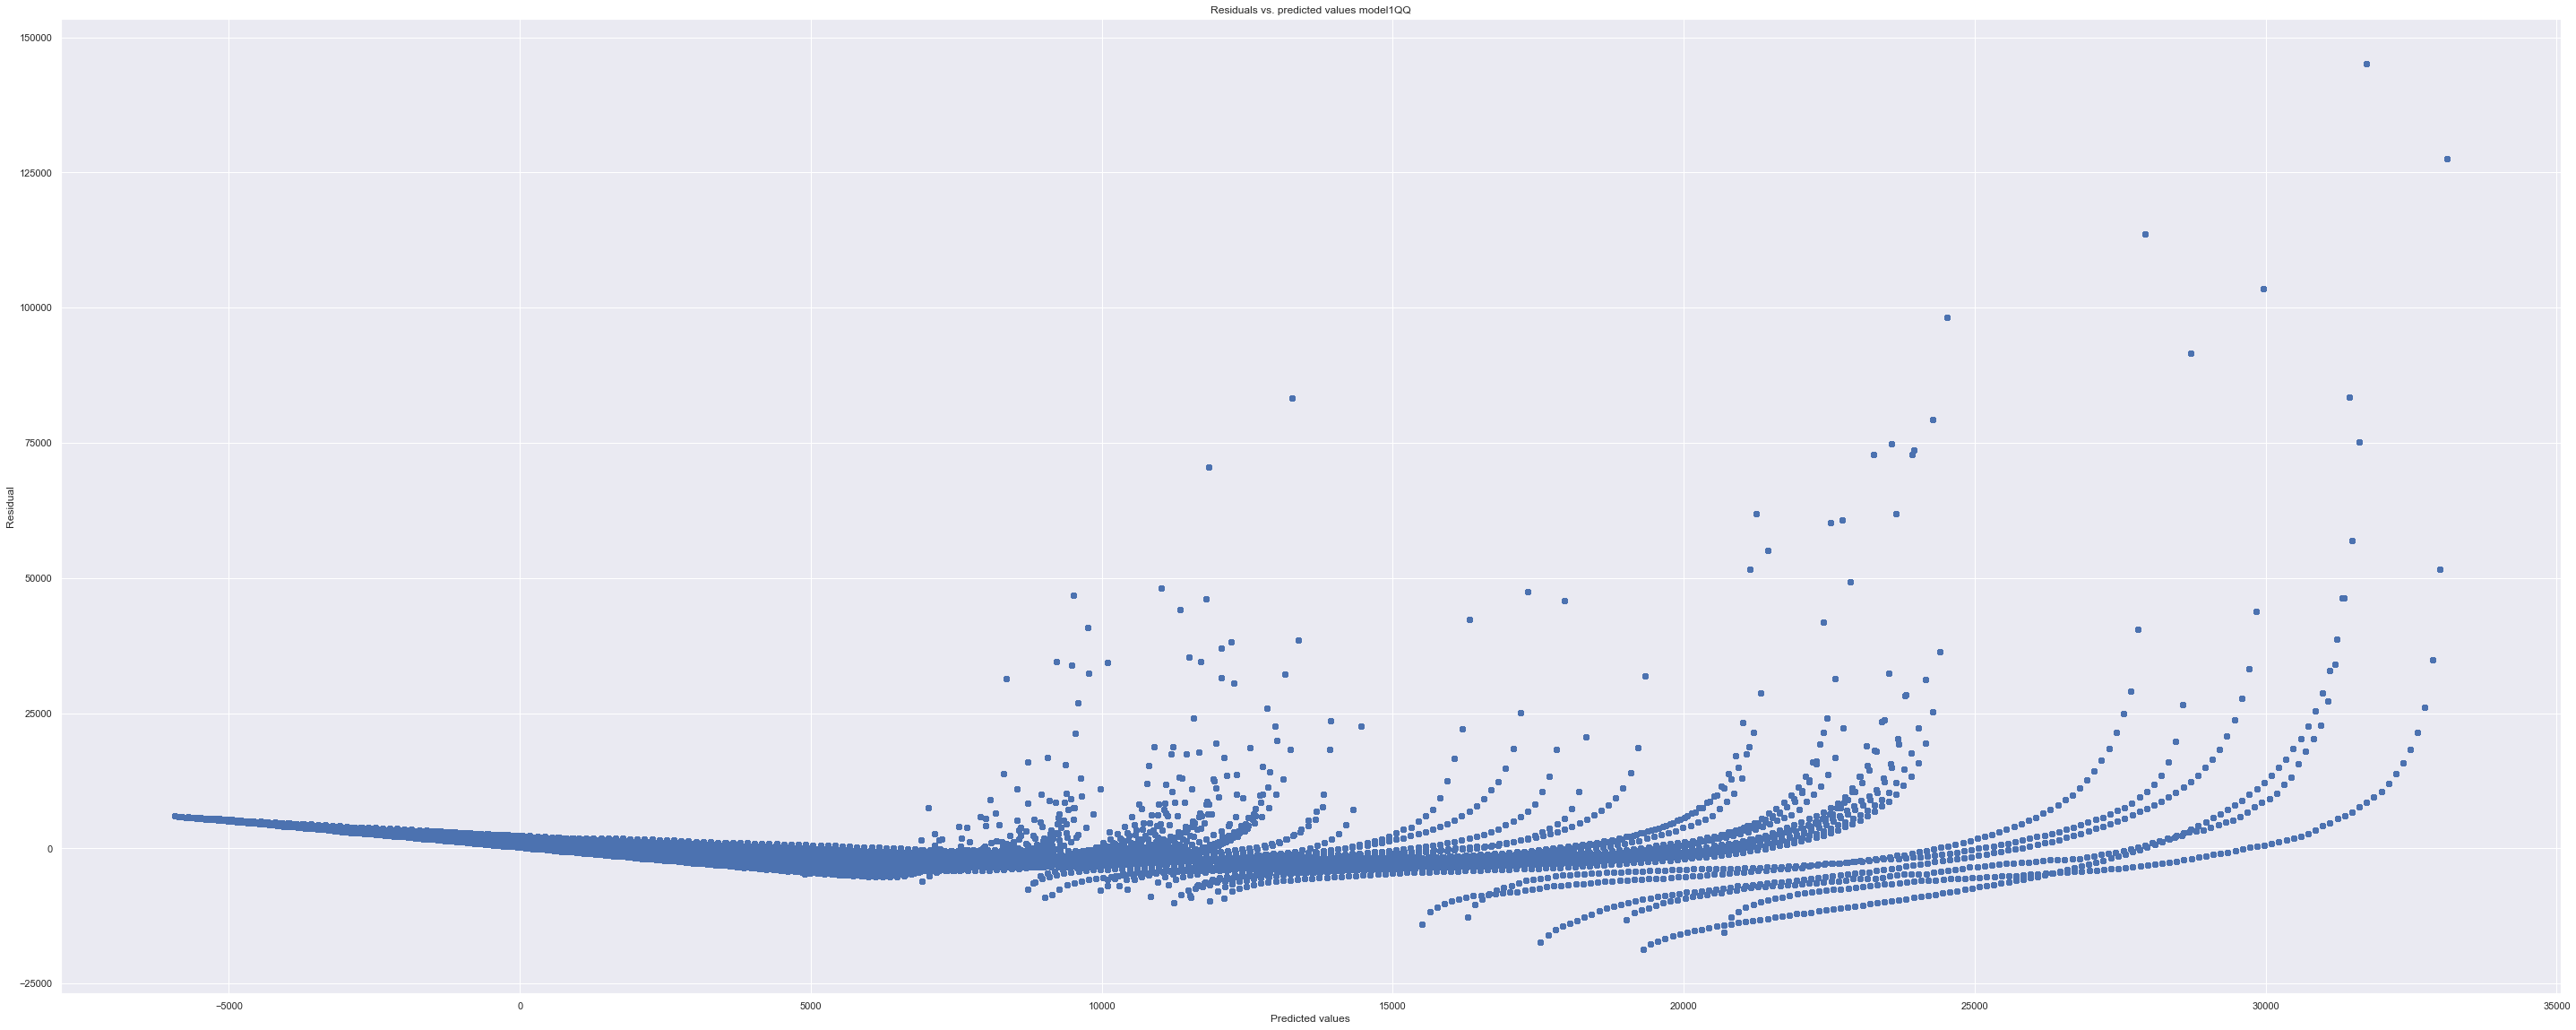

In [147]:
resid_plot(df_y_test, df_y_pred, "model1QQ")

In [148]:
y = df2["income"]
X = df2[["income_moyen","indice", "c_i_child"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Instanciation du modèle
linreg = LinearRegression()
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [149]:
# Entraînement du modèle sur le jeu d'entraînement
linreg.fit(X_train, y_train)
# Prédiction de la variable cible pour le jeu de données test. Ces prédictions sont stockées dans y_pred
y_pred_train = linreg.predict(X_train)
y_pred_test = linreg.predict(X_test)
mse_train=mean_squared_error(y_train,y_pred_train)
mse_test=mean_squared_error(y_test,y_pred_test)
print("MSE_train= ",mse_train)
print("MSE_test= ",mse_test)

MSE_train=  0.07758287375912755
MSE_test=  0.07818603223839189


In [150]:
print_metrics(y_test, y_pred_test)

Mean Square Error      = 0.07818603223839189
Root Mean Square Error = 0.2796176536601219
Mean Absolute Error    = 0.17580226642982943
Median Absolute Error  = 0.1306984673359608
R^2                    = 0.9589646993557204


C:\Users\jb-14\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


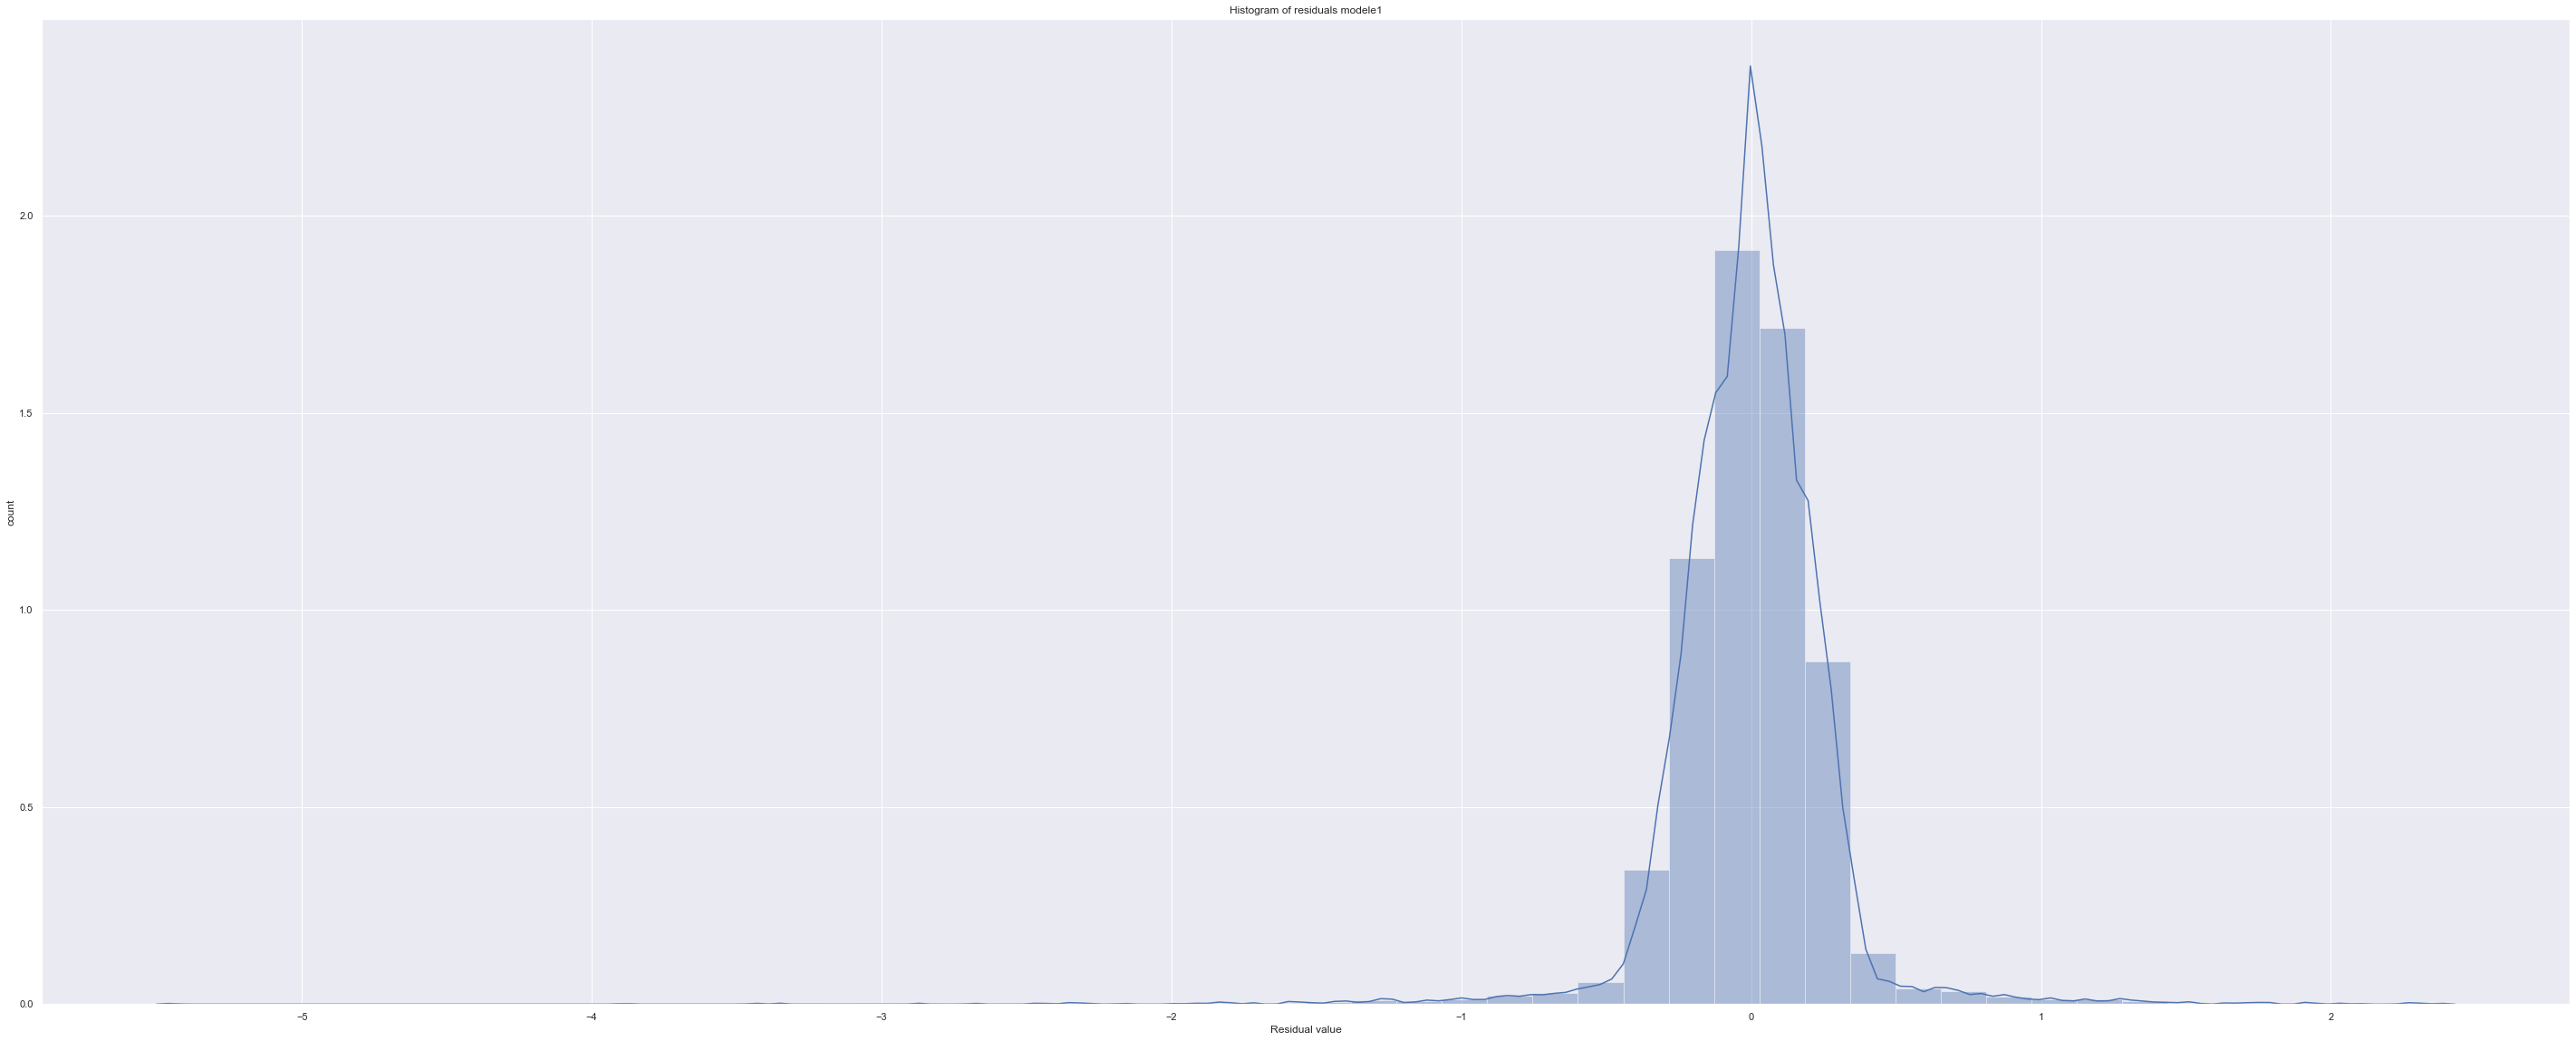

In [151]:
df_y_test = np.array(y_test)
df_y_pred = np.array(y_pred_test)
hist_resids(df_y_test, df_y_pred, "modele1")

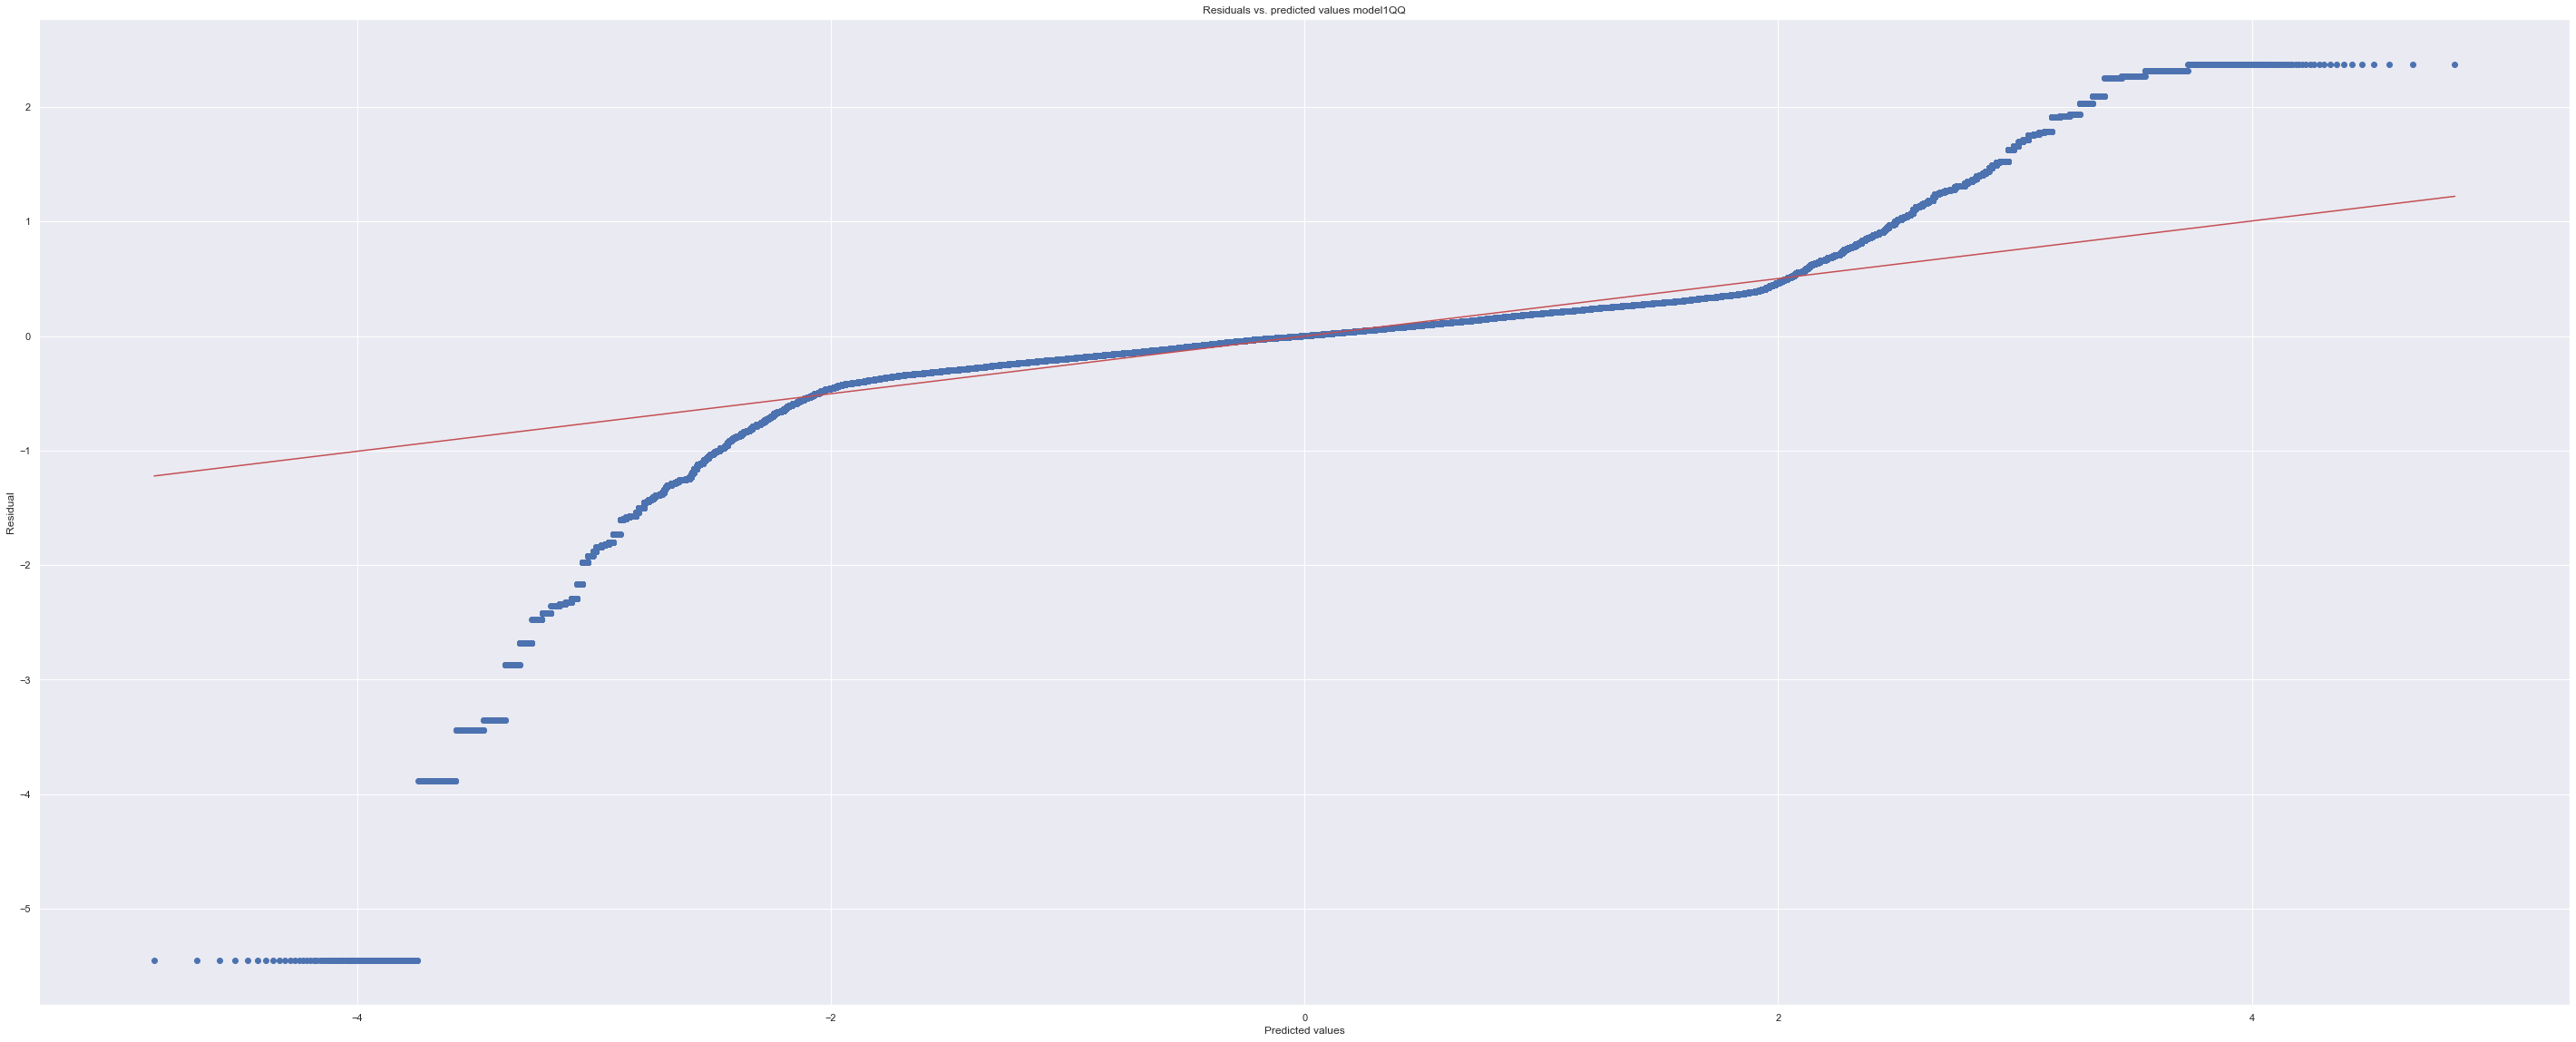

In [152]:
resid_qq(df_y_test, df_y_pred, "model1QQ")

C:\Users\jb-14\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


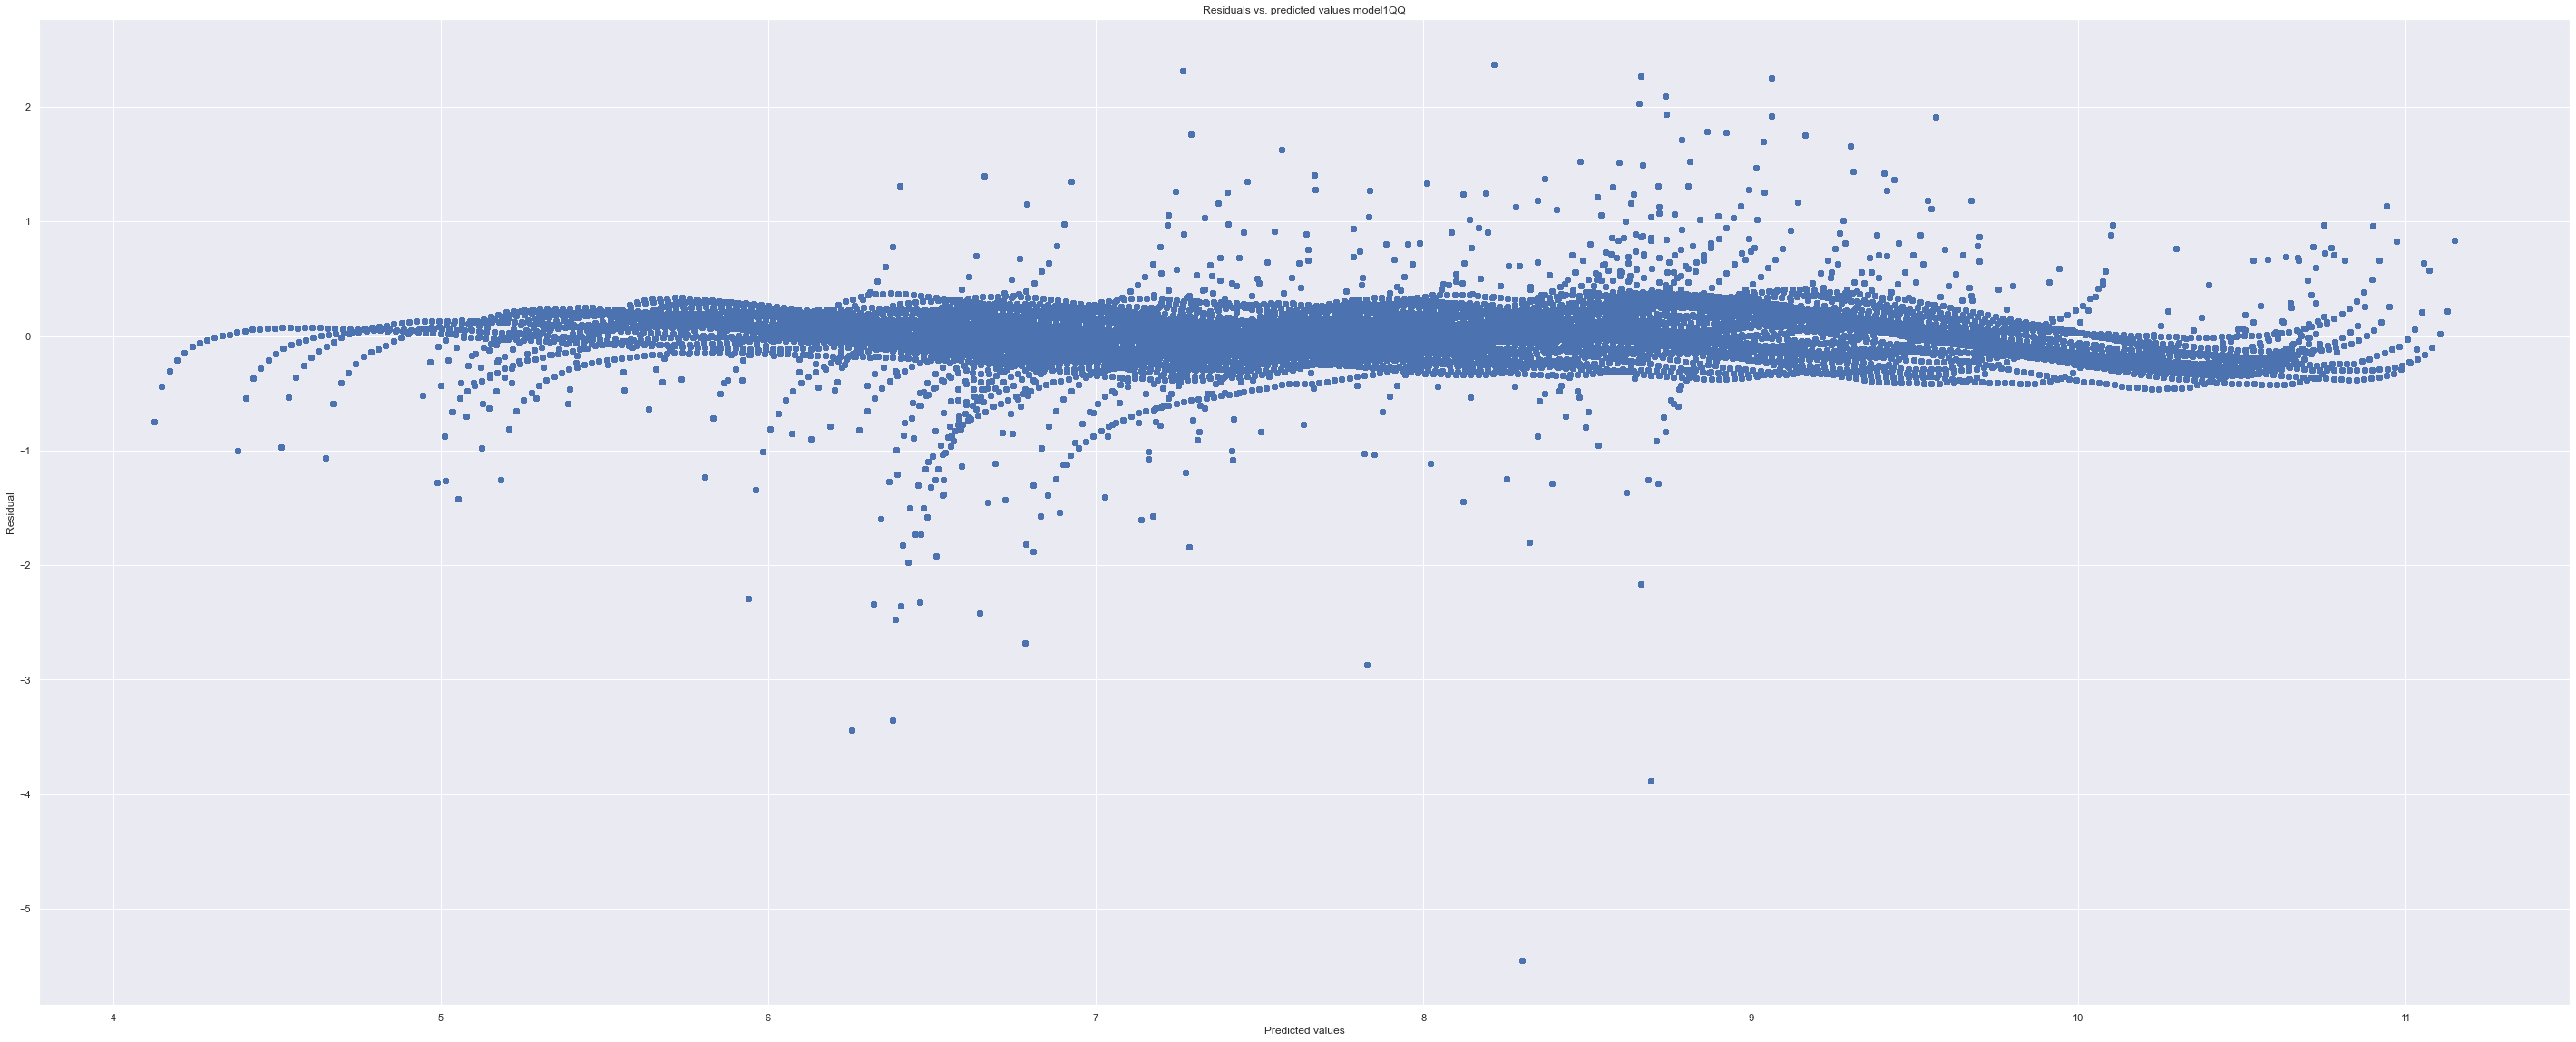

In [153]:
resid_plot(df_y_test, df_y_pred, "model1QQ")